<div id="container" style="position:relative;">
<div style="float:left"><h1> Model 3 : SARIMAX Forecast </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://twomagpiesbakery.co.uk/wp-content/uploads/2020/11/logo-no-site.jpg" />
</div>
</div>

**Steps to calculate an SARIMAX model for a daily, weekly and monthly revenue forecast.**
 
In order for a successful SARIMAX model there are a few assumptions about the data that must be made, these are:

- The data is stationary 
- Residuals are normally distributed and show no significant correlation


If these are not met, revenue forecasts will be less accurate. 

**Accuracy Evaluation** 
The models will then be evaluated by calculating the:  
- Mean Absolute Percentage Error (MAPE) value, which is the percentage of the average absolute values of error between the true revenue values and the predicted ones. For full discussion on why this accuracy metric was determined please see `Model 2: Linear Regression Weekly Forecast`.

The model with the best evaluation scores will be selected as the optimal SARIMAX model for the daily, weekly and monthly forecast. 

---

# Contents 

**[Exploration into Trends](#Exploration-into-Trends)**

**[1. Daily Revenue Forecast](#1.-Daily-Revenue-Forecast)**

   - [Daily Revenue Model Results Discussion](#Daily-Revenue-Model-Results-Discussion)
    
**[2. Weekly Revenue Forecast](#2.-Weekly-Revenue-Forecast)**

   - [Weekly Revenue Model Results Discussion](#Weekly-Revenue-Model-Results-Discussion)

**[3. Monthly Revenue Forecast](#3.-Monthly-Revenue-Forecast)**

   - [Monthly Revenue Model Results Discussion](#Monthly-Revenue-Model-Results-Discussion)
    
**[Summary](#Summary)**

**[Further Improvements](#Further-Improvements)**

**[Next Steps](#Next-Steps)**
___

## Imports

In [1]:
import numpy as np
import pandas as pd
import itertools

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
import statsmodels.api as sm
from statsmodels.api import tsa # time series analysis
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# time
import datetime as dt
import time
import os

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize']=[10,7.5]

## Importing Custom Functions

In [2]:
import BakeryFunctions as bakery

## To Get Current Directory

In [3]:
working_directory = os.getcwd()
working_directory

'/Users/abimagnall/Documents/BrainStation/Capstone/Data'

## Importing Processed Datasets

In [4]:
total_rev = pd.read_csv(working_directory+'/5_timeseries_data/total_revenue_encoded.csv', index_col=0)
total_rev.index = pd.to_datetime(total_rev.index)
display(total_rev.head())

Total_Revenue  TAVG  PRCP  CPI_Electricity  CPI_Food  \
2020-09-01        9780.76  24.0  0.00            107.6     102.8   
2020-09-02       10037.55  27.0  0.00            107.6     102.8   
2020-09-03        9419.30  31.0  0.07            107.6     102.8   
2020-09-04       10606.15  27.0  0.08            107.6     102.8   
2020-09-05       12922.00  23.0  0.01            107.6     102.8   

            Bank_Holiday  Closed_Xmas  School_Holiday  Weekday  Weekend  
2020-09-01             0            0               0        1        0  
2020-09-02             0            0               0        1        0  
2020-09-03             0            0               0        1        0  
2020-09-04             0            0               0        1        0  
2020-09-05             0            0               0        0        1

---

# Exploration into Trends
SARIMAX models work by decomposing the data into the trend, seasonal and residual components. Therefore, it is required to understand the trends and seasonal components in the data, in order to enter the correct hyperparameters for an accurate model to be fitted. To do this, the data will be: 
- Trends and seasonality explored over time
- Data decomposed to be stationary (determine the baseline `d parameter`)
- Autocorrelation and Partial Autocorrelation Functions (ACF and PACF) plotted to determine baseline `p and q parameters`

## Exploring Revenue Trends

In [5]:
# To create the daily revenue dataframe
total_rev_daily = total_rev.drop(columns=['TAVG','PRCP','CPI_Electricity','CPI_Food',
                                         'Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend']).copy()
total_rev_daily.head()

Total_Revenue
2020-09-01        9780.76
2020-09-02       10037.55
2020-09-03        9419.30
2020-09-04       10606.15
2020-09-05       12922.00

In [78]:
# To create the weekly revenue dataframe
total_rev_weekly = total_rev.resample('W').sum().round(2)
total_rev_weekly = total_rev_weekly[:-1]
total_rev_weekly.drop(columns=['TAVG', 'PRCP','CPI_Electricity','CPI_Food',
                              'Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend'], inplace=True)
display(total_rev_weekly.head())

Total_Revenue
2020-09-06       62891.56
2020-09-13       64159.55
2020-09-20       65532.19
2020-09-27       58612.25
2020-10-04       52732.89

In [7]:
# To create the monthly revenue dataframe
total_rev_monthly = total_rev.resample('MS').sum().round(2)
total_rev_monthly.drop(columns=['TAVG','PRCP','CPI_Electricity','CPI_Food',
                               'Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend'], inplace=True)
display(total_rev_monthly.head())

Total_Revenue
2020-09-01      271314.93
2020-10-01      267385.25
2020-11-01      143635.13
2020-12-01      173145.73
2021-01-01       95207.98

In [628]:
# Plot all revenue trends over time
rev_dfs = [total_rev_daily, total_rev_weekly, total_rev_monthly]
cols = ['Daily Revenue', 'Weekly Revenue', 'Monthly Revenue']
fig = make_subplots(rows=3, cols=1, subplot_titles=cols, vertical_spacing=0.05)

for i, df in enumerate(rev_dfs):
    fig.add_trace(
        go.Scatter(x=df.index, y=df['Total_Revenue']),
        row=i+1,
        col=1
    )

fig.update_layout(height=1000, width=1000, showlegend=False)
fig.show()

## Trend Observations 
All plots show: 
- A general increase in revenue over time 
- A seasonal trend, with revenue peaking in the summer months and dipping in the winter months 

## Seasonal Plot
In order to explore seasonality further and across multiple years the `seasonal plot` is used.

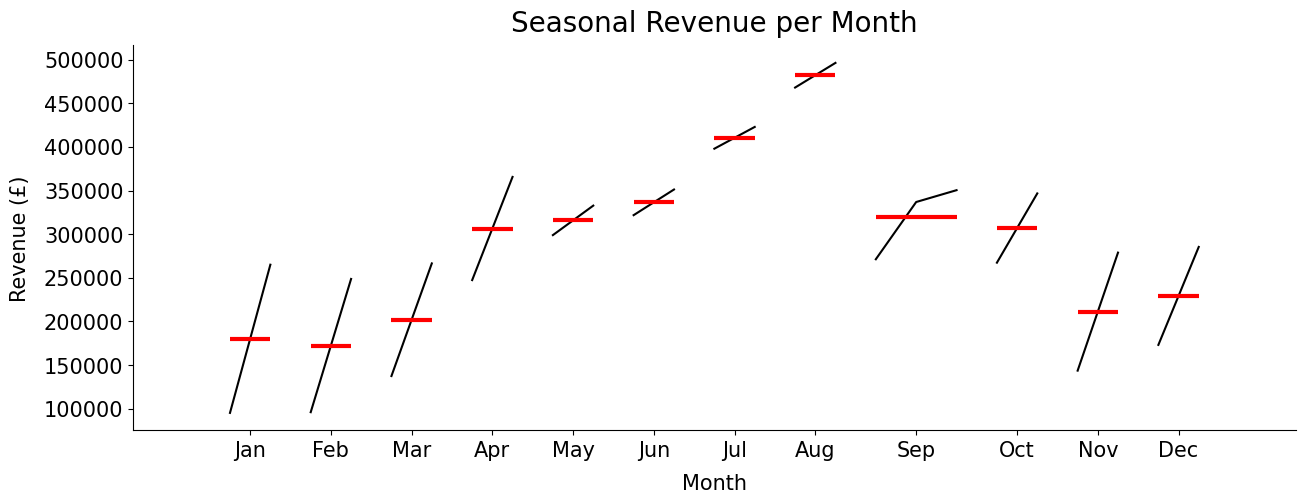

In [10]:
plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(total_rev_monthly['Total_Revenue'], ax=plt.gca())
plt.title('Seasonal Revenue per Month', fontsize=20, pad=10)
plt.ylabel('Revenue (£)', fontsize=15, labelpad=10)
plt.xlabel('Month', fontsize=15, labelpad=10)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
sns.despine()
plt.show()

## Seasonal Plot Observations
The red bars show the average for the given month across all years, while each black line represents an individual month and the progression of values across the years. 

- It can be seen the upward trend for each month and that on average that the late summer months (July and August) generate more revenue and the winter months perform least. 

Now the yearly periods are better understood, the average revenue for each month will be evaluated against how much it differs from the overall average.

In [13]:
# monthly average
monthly_mean = total_rev_monthly['Total_Revenue'].groupby(total_rev_monthly.index.month_name()).mean()
# relative deviation from the overall mean
monthly_mean_diff = round((monthly_mean - monthly_mean.mean())/monthly_mean,4)
# month names in right order
month_names = pd.date_range(start='2020-09', freq='M', periods=12).month_name()
# reorder columns to follow the month order
monthly_mean_diff = monthly_mean_diff.loc[month_names, ]

In [629]:
# To plot the monthly difference
fig = px.bar(monthly_mean_diff)

fig.update_layout(
    yaxis_title='', 
    yaxis_tickformat = '.0%',
    xaxis_title='',
    title='Monthly Deviation From Mean Monthly Revenue (%)',
    showlegend=False,
)
fig.show()

## Monthly Deviation Observations
It can be seen that the winter months November - Feburary deviate most from the mean monthly revenue. However, this could be due to the first winter season being in 2020, which was recently after the Covid Pandemic, therefore sales were perhaps lower than usual. 

---

# Trend-Seasonal Decomposition
A fundamental step in time series EDA is the trend-seasonal decomposition. Here, three series are extracted from the original observation:

- A trend component  𝑇𝑡  calculated using a moving average,
- A seasonal component  𝑆𝑡  which is the average of the de-trended series
- The residual  𝑅𝑡  that remains after subtracting the trend and seasonal component from the original series.

This is implemented using the `seasonal_decompose` function from the time series analysis module of statsmodels.

## Daily Decomposition
This is done using `additive` as opposed to `multiplicative`, which was determined by looking at the data, where the seasonal variation appears to be constant over time. Furthermore, multiplicative decomposition does not work if there a values of 0 in the dataset, which there are for the daily revenue from the 2 Christmas Days where the shop was closed. 

In [15]:
# decompose the time series
d_decomposition_add = tsa.seasonal_decompose(total_rev_daily, model='additive',
                                             period = 365, extrapolate_trend='freq')
daily_add_decom = total_rev_daily.copy()

In [16]:
# add the decomposition data
daily_add_decom['Trend'] = d_decomposition_add.trend
daily_add_decom['Seasonal'] = d_decomposition_add.seasonal
daily_add_decom['Residual'] = d_decomposition_add.resid
daily_add_decom['Original - trend'] = daily_add_decom['Total_Revenue'] - d_decomposition_add.trend

daily_add_decom.head(10)

Total_Revenue        Trend     Seasonal     Residual  \
2020-09-01        9780.76  6275.789062  1749.461864  1755.509074   
2020-09-02       10037.55  6285.266580  2109.639991  1642.643429   
2020-09-03        9419.30  6294.744098  3322.369826  -197.813924   
2020-09-04       10606.15  6304.221616  3198.352099  1103.576285   
2020-09-05       12922.00  6313.699134  2256.137085  4352.163781   
2020-09-06       10125.80  6323.176652   836.954953  2965.668395   
2020-09-07        9082.50  6332.654170   -20.477721  2770.323551   
2020-09-08        8559.20  6342.131689  -199.747686  2416.815998   
2020-09-09        8102.42  6351.609207    82.046190  1668.764603   
2020-09-10        8120.49  6361.086725  2909.168995 -1149.765720   

            Original - trend  
2020-09-01       3504.970938  
2020-09-02       3752.283420  
2020-09-03       3124.555902  
2020-09-04       4301.928384  
2020-09-05       6608.300866  
2020-09-06       3802.623348  
2020-09-07       2749.845830  
2020-09-08       2217.068311  
2020-09-09       1750.810793  
2020-09-10       1759.403275

In [18]:
cols = ['Total_Revenue','Trend', 'Original - trend', 'Seasonal', 'Residual']
fig = make_subplots(rows=5, cols=1, subplot_titles=cols, vertical_spacing=0.05)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=daily_add_decom.index, y=daily_add_decom[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=1000, width=1000, showlegend=False)
fig.show()

## Observations 
- The trend is clearly upward, with a big step around April 2022 - this is most likely due to the Easter holidays / bank holiday. 

- The seasonal plot shows that revenue peaks in the summer months and dips in the winter months, with a sharp decline on December 25th, where the shops were closed for Christmas Day. 

- The residual still shows some seasonality, however it is very minimal. This will be further decomposed to reduce the seasonality in the differencing stage of the SARIMAX model. 

# Selecting Baseline Hyperparameters
For the baseline model, the hyperparameters need to be determined. These parameters are: 
- p: Trend autoregression order
- d: Trend difference order
- q: Trend moving average order
- P: Seasonal autoregressive order
- D: Seasonal difference order
- Q: Seasonal moving average order
- m: The number of time steps for a single seasonal period

For daily revenue `m` is equal to 7 (as there are 7 days in the seasonal period), 52 for weekly revenue and 12 for monthly revenue.  

To determine the `d` value, this is done by testing if the data is stationary. This is an assumption that must be met for an accurate SARIMAX model. This is important as when running a linear regression, it is assumed that all the observations are independent from one another. However, in a time series that is often not the case, and is not for bakery revenue, therefore the data must be made stationary so that regression techniques can be applied. 

---

# 1. Daily Revenue Forecast
## Selecting Baseline Parameters 
First the original daily data and differenced data will be visualised to see if the data becomes stationary and then the `Dickey-Fuller Test` can be run to confirm that it is. The weekly and monthly will have be decomposed later in [2. Weekly Revenue Forecast](#2.-Weekly-Revenue-Forecast) and [3. Monthly Revenue Forecast](#3.-Monthly-Revenue-Forecast)

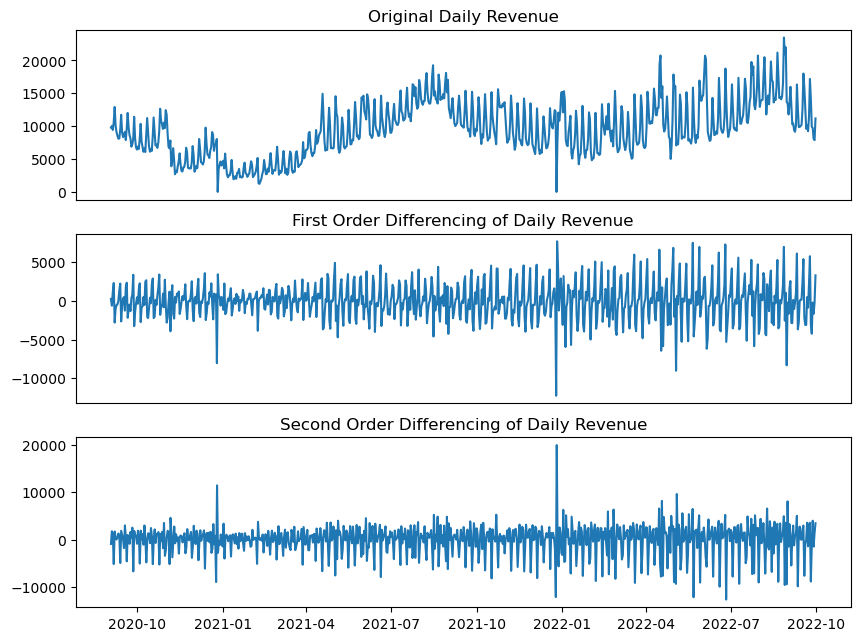

In [20]:
# Subplots of orginal and differenced daily data 
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(daily_add_decom['Total_Revenue']); ax1.set_title('Original Daily Revenue'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(daily_add_decom['Total_Revenue'].diff()); ax2.set_title('First Order Differencing of Daily Revenue'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(daily_add_decom['Total_Revenue'].diff().diff()); ax3.set_title('Second Order Differencing of Daily Revenue')
plt.show()

## Observations
It appears that the first and second order differenced data is stationary as the plot above shows: 
- There is no clear trend in the new series,
- The variance is relatively constant, and
- There is no seasonality 

The second order differenced dataset appears to be more stationary than the first order. This can be confirmed using the `Dickey-Fuller Test`. 

## Dickey-Fuller Test for Stationarity
Null hypothesis: 

$H$<sub>0</sub>: The time series is non-stationary, meaning it has some time-dependent structure and does not have constant variance over time.


$H$<sub>A</sub>: The time series is stationary.

In [18]:
#perform augmented Dickey-Fuller test
adfuller(daily_add_decom['Total_Revenue'].diff().diff().dropna())

(-12.889893541644302,
 4.471712378090714e-24,
 20,
 737,
 {'1%': -3.4392539652094154,
  '5%': -2.86546960465041,
  '10%': -2.5688625527782327},
 12969.587710892225)

**Dickey-Fuller Test Output**

|Revenue| Test Statistic | p-value |
|:--| :- | :- | 
|Daily|-12.890| 4.472 *e*<sup>-11</sup>|

The p-value is less than 0.05, therefore can reject the null hypothesis that the time series is non-stationary. Therefore, the `d parameter` for the baseline model shall be 2. 

---

## Determining the `p` and `q` Parameters for Daily Baseline
Autocorrelation plots help determine if the successive elements of a time series are positively correlated, negatively correlated, or independent of each other. Analysing the autocorrelations is a key step in finding the right `p` and `q` parameters for (autoregressive) time series models.

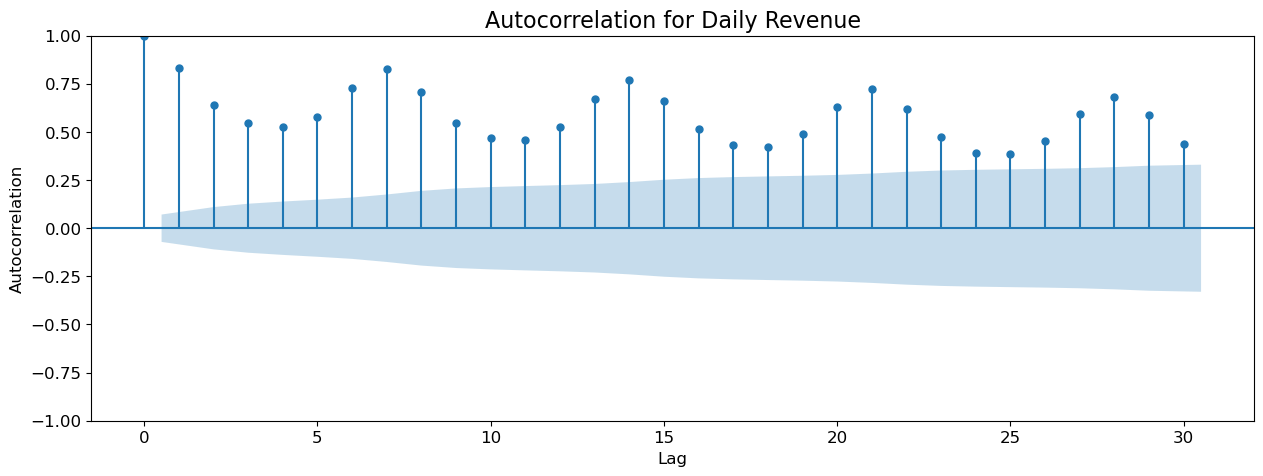

In [21]:
# Plotting autocorrelation plot on the original daily dataset
plt.figure(figsize=(15, 5))
plot_acf(daily_add_decom['Total_Revenue'], lags=30, ax=plt.gca())
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Autocorrelation for Daily Revenue', fontsize=16)
plt.show()

**ACF Plot Observations**: Looking at the original revenue first, the seasonality of the data is clearly visible in the autocorrelation plot as as each lag is correlated to the every other lag, peaking on multiples of 7 (for each week). 

Therefore, the differenced data will be plotted to determine the p and q parameters required for the baseline model. 

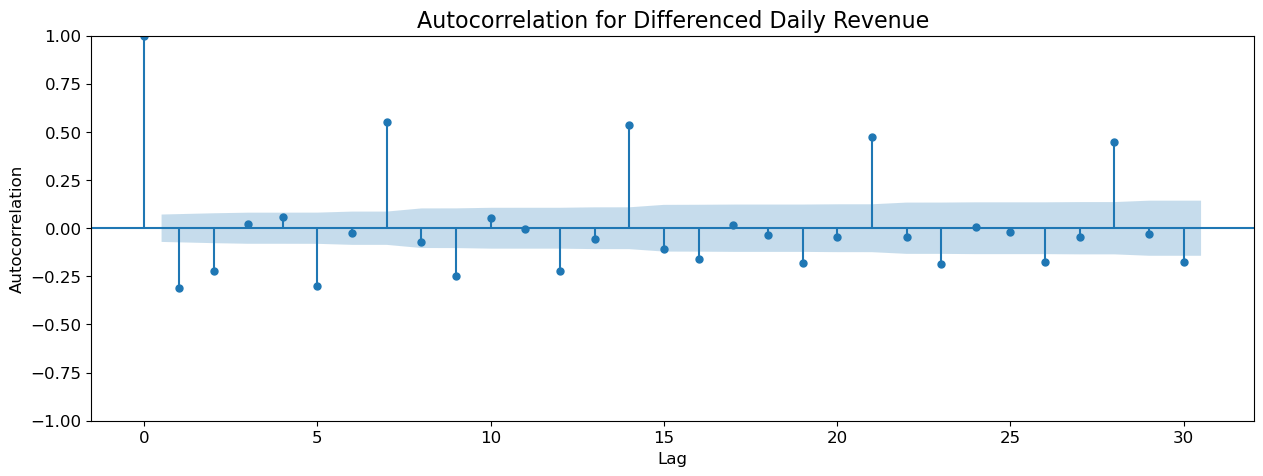

In [22]:
# Plotting the autocorrelation of the differenced data 
plt.figure(figsize=(15, 5))
plot_acf(daily_add_decom['Total_Revenue'].diff().diff().dropna(), lags=30, ax=plt.gca())
plt.ylabel('Autocorrelation', fontsize=12)
plt.xlabel('Lag', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Autocorrelation for Differenced Daily Revenue', fontsize=16)
plt.show()

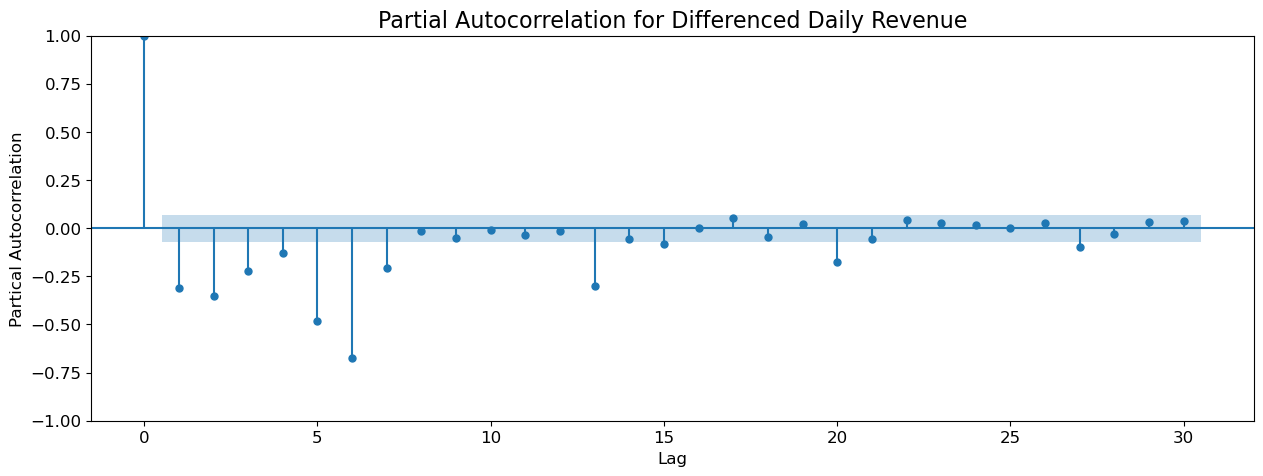

In [24]:
# To plot the partial autocorrelation of differenced data 
plt.figure(figsize=(15, 5))
plot_pacf(daily_add_decom['Total_Revenue'].diff().diff().dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Partical Autocorrelation', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Partial Autocorrelation for Differenced Daily Revenue', fontsize=16)
plt.show()

## ACF and PACF Observations
Picking the right order parameter `p` and `q` , should include all or most of the significant correlations in the PACF plot.
- From the PACF plot it can be seen that `p = 7` for the daily baseline model

- From the ACF plot, it can be determined that for the baseline model `q = 2`. 

## Splitting the Series for Evaluation

First the data is split into train and test sets as determined by the business, which is to predict the next 7 days of revenue.

*Therefore, anything before the date 24-09-2022 is the train dataset and on or post is test dataset.*

In [25]:
# Splitting the train and test data
train_daily = daily_add_decom.loc[daily_add_decom.index <= '2022-09-23', 'Total_Revenue'].dropna().copy()
test_daily = daily_add_decom.loc[daily_add_decom.index > '2022-09-23', 'Total_Revenue'].copy()

---

# Model 1 - Baseline SARIMAX
For the first baseline SARIMAX model, a model will be run using the following parameters: 
- p = 7
- d = 2
- q = 2

As determined by the above stationary tests, ACF and PACF plots. 

In [86]:
# First an empty results dataframe is created to track the accuracy of the models run
daily_model_scores = pd.DataFrame()

In [27]:
# Baseline model run 
p_param = 7
d_param = 2
q_param = 2

model = SARIMAX(train_daily, order=(p_param, d_param, q_param), seasonal_order = (0, 2, 2, 7), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     Total_Revenue   No. Observations:                  753
Model:             SARIMAX(7, 2, 2)x(0, 2, 2, 7)   Log Likelihood               -6686.430
Date:                           Mon, 31 Oct 2022   AIC                          13398.860
Time:                                   19:12:41   BIC                          13458.694
Sample:                               09-01-2020   HQIC                         13421.934
                                    - 09-23-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0309      0.078      0.396      0.692      -0.122       0.184
ar.L1         -1.2031      0.093    -12.921      0.000      -1.386      -1.021
ar.L2         -0.5656      0.137     -4.139      0.000      -0.833      -0.298
ar.L3         -0.5035      0.172     -2.919      0.004      -0.842      -0.165
ar.L4         -0.2627      0.199     -1.319      0.187      -0.653       0.128
ar.L5         -0.4542      0.199     -2.287      0.022      -0.843      -0.065
ar.L6         -0.4925      0.193     -2.548      0.011      -0.871      -0.114
ar.L7         -0.1321      0.136     -0.971      0.331      -0.398       0.134
ma.L1          0.0149      0.095      0.157      0.875      -0.171       0.201
ma.L2         -0.9528      0.071    -13.396      0.000      -1.092      -0.813
ma.S.L7       -1.9447      0.062    -31.576      0.000      -2.065      -1.824
ma.S.L14       0.9489      0.063     15.175      0.000       0.826       1.071
sigma2      8.454e+06   1.07e-08   7.91e+14      0.000    8.45e+06    8.45e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.22   Jarque-Bera (JB):              6898.98
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                            -1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.23e+30. Standard errors may be unstable.
"""

In [28]:
predictions_1 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1)

In [29]:
bakery.train_forecast_plot(train_daily,test_daily, predictions_1, 'Model 1 - Baseline Daily Forecast')

In [30]:
bakery.full_accuracy_report(test_daily, predictions_1[test_daily.index], 'daily forecast')

The RMSE for the daily forecast is: 1210.26

The MAE between the actual and daily forecast revenue is 927.75

The MAPE between the actual and daily forecast revenue is 10.5%


In [87]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 1, 'N/A', 1210.26, 13398.860, '10.5%', 'p=7, d=2, q=2')

Model   R2     RMSE       AIC MAPE (%)       Comments
0      1  N/A  1210.26  13398.86    10.5%  p=7, d=2, q=2

# SARIMAX Grid Search to Tune Hyperparameters
To tune the hyperparameters for the SARIMAX model, the `evaluate_models` and `evaluate_sarimax_model` functions are used. These functions work by trying multiple orders of p,d,q and seasonal order parameters, as inputted and determining which combination creates a model with the lowest MAPE score. This is done on train data only, so that no test data leaks into the model creating an inaccurate and overfitted model. 

In [32]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 7]
d_values = range(0, 3)
q_values = range(0, 3)
s_range = range(0,2)
warnings.filterwarnings("ignore")
bakery.evaluate_models(train_daily.values, p_values, d_values, q_values, None, s_range, 7, 0.9)

The Best SARIMAX (2, 2, 2) SEASONAL(1, 0, 0, 7) MAPE=0.136


# Model 2 - SARIMAX with Tuned Hyperparameters

In [33]:
# Best hyperparameters 
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_daily, order=(p_param, d_param, q_param), seasonal_order = (1, 0, 0, 7), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  753
Model:             SARIMAX(2, 2, 2)x(1, 0, [], 7)   Log Likelihood               -6690.310
Date:                            Mon, 31 Oct 2022   AIC                          13394.620
Time:                                    19:18:38   BIC                          13426.970
Sample:                                09-01-2020   HQIC                         13407.084
                                     - 09-23-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1496      0.478     -0.313      0.754      -1.086       0.787
ar.L1         -1.0015      0.063    -15.923      0.000      -1.125      -0.878
ar.L2         -0.0560      0.032     -1.770      0.077      -0.118       0.006
ma.L1         -0.1164      0.067     -1.730      0.084      -0.248       0.016
ma.L2         -0.8836      0.060    -14.694      0.000      -1.002      -0.766
ar.S.L7        0.6924      0.021     33.506      0.000       0.652       0.733
sigma2      3.151e+06    1.5e-08   2.11e+14      0.000    3.15e+06    3.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              2764.47
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.49   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.39e+30. Standard errors may be unstable.
"""

In [34]:
predictions_2 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1)

In [35]:
bakery.train_forecast_plot(train_daily,test_daily, predictions_2, 'Model 2 - Grid Search Daily Forecast')

In [36]:
bakery.full_accuracy_report(test_daily, predictions_2[test_daily.index], 'daily forecast')

The RMSE for the daily forecast is: 1255.7

The MAE between the actual and daily forecast revenue is 1136.67

The MAPE between the actual and daily forecast revenue is 10.7%


In [88]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 2, 'N/A', 1255.7, 13394.620, '10.7%', 'p=2, d=2, q=2')

Model   R2     RMSE       AIC MAPE (%)       Comments
0      1  N/A  1210.26  13398.86    10.5%  p=7, d=2, q=2
1      2  N/A  1255.70  13394.62    10.7%  p=2, d=2, q=2

# Model 3 - Reducing `p_param` and `q_param`
From the above summary table, it can be seen that one of the moving average and one of the autoregressive coefficients have p-values greater than 0.05, therefore aren't deemed statistically significant. Therefore, for the next iteration of the model, the `p` and `q` parameters will be reduced to 1. 

In [38]:
# Reducing p and q hyperparameters 
p_param = 1
d_param = 2
q_param = 1

model = SARIMAX(train_daily, order=(p_param, d_param, q_param), seasonal_order = (1, 0, 0, 7), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  753
Model:             SARIMAX(1, 2, 1)x(1, 0, [], 7)   Log Likelihood               -6698.670
Date:                            Mon, 31 Oct 2022   AIC                          13407.340
Time:                                    19:18:46   BIC                          13430.447
Sample:                                09-01-2020   HQIC                         13416.243
                                     - 09-23-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0820      0.257     -0.319      0.750      -0.586       0.422
ar.L1         -0.1447      0.020     -7.131      0.000      -0.184      -0.105
ma.L1         -1.0000      0.025    -39.608      0.000      -1.049      -0.951
ar.S.L7        0.6815      0.020     33.378      0.000       0.642       0.722
sigma2      3.222e+06   7.84e-09   4.11e+14      0.000    3.22e+06    3.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              2782.76
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+30. Standard errors may be unstable.
"""

In [39]:
predictions_3 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1)

In [40]:
bakery.train_forecast_plot(train_daily,test_daily, predictions_3, 'Model 3 - Reducing the p and q Parameters')

In [41]:
bakery.full_accuracy_report(test_daily, predictions_3[test_daily.index], 'daily forecast')

The RMSE for the daily forecast is: 1279.86

The MAE between the actual and daily forecast revenue is 1158.97

The MAPE between the actual and daily forecast revenue is 10.8%


In [89]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 3, 'N/A', 1279.86, 13407.340, '10.8%', 'p=1, d=2, q=1')

Model   R2     RMSE       AIC MAPE (%)       Comments
0      1  N/A  1210.26  13398.86    10.5%  p=7, d=2, q=2
1      2  N/A  1255.70  13394.62    10.7%  p=2, d=2, q=2
2      3  N/A  1279.86  13407.34    10.8%  p=1, d=2, q=1

# Model 4 - Adding Exogenous Data
For the next iteration of the model, special days and average temperature data will be added to see if this improves the models MAPE accuracy score. The same initial hyperparameters will be used from the baseline model. 

In [657]:
exogenous_variables = total_rev[['TAVG','Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend']].copy()
# Splitting the train and test data
train_ex = exogenous_variables.loc[exogenous_variables.index <= '2022-09-23'].copy()
test_ex = exogenous_variables.loc[exogenous_variables.index > '2022-09-23'].copy()

In [44]:
# Baseline model run with special dates added
p_param = 7
d_param = 2
q_param = 2

model = SARIMAX(train_daily, order=(p_param, d_param, q_param), seasonal_order = (0, 2, 2, 7), 
                exog=train_ex, trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     Total_Revenue   No. Observations:                  753
Model:             SARIMAX(7, 2, 2)x(0, 2, 2, 7)   Log Likelihood               -6555.813
Date:                           Mon, 31 Oct 2022   AIC                          13149.626
Time:                                   19:19:10   BIC                          13237.075
Sample:                               09-01-2020   HQIC                         13183.349
                                    - 09-23-2022                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0101      0.092     -0.110      0.912      -0.190       0.170
TAVG              39.7157     55.710      0.713      0.476     -69.473     148.905
Bank_Holiday    3445.0777   1.16e+04      0.296      0.767   -1.94e+04    2.63e+04
Closed_Xmas    -5268.7596   1.14e+04     -0.461      0.645   -2.77e+04    1.71e+04
School_Holiday  1204.3546   1.15e+04      0.104      0.917   -2.14e+04    2.38e+04
Weekday         -122.8679   1.16e+04     -0.011      0.992   -2.29e+04    2.27e+04
Weekend          742.1996   1.15e+04      0.065      0.949   -2.18e+04    2.33e+04
ar.L1             -0.6469      6.708     -0.096      0.923     -13.795      12.501
ar.L2             -0.3174      1.767     -0.180      0.857      -3.780       3.146
ar.L3             -0.2171      1.487     -0.146      0.884      -3.131       2.697
ar.L4             -0.1489      0.918     -0.162      0.871      -1.948       1.650
ar.L5             -0.2452      0.699     -0.351      0.726      -1.615       1.125
ar.L6             -0.1424      1.451     -0.098      0.922      -2.987       2.702
ar.L7             -0.0074      0.537     -0.014      0.989      -1.059       1.044
ma.L1             -0.6002      6.712     -0.089      0.929     -13.756      12.555
ma.L2             -0.3836      6.621     -0.058      0.954     -13.361      12.594
ma.S.L7           -1.7796      0.125    -14.283      0.000      -2.024      -1.535
ma.S.L14           0.7937      0.126      6.295      0.000       0.547       1.041
sigma2          6.295e+06     32.220   1.95e+05      0.000     6.3e+06     6.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               699.27
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.93e+21. Standard errors may be unstable.
"""

In [45]:
predictions_4 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1, exog=test_ex)

In [46]:
bakery.train_forecast_plot(train_daily, test_daily, predictions_4, 'Model 4 - Baseline Adding Special Days and TAVG')

In [47]:
bakery.full_accuracy_report(test_daily, predictions_4[test_daily.index], 'daily forecast with special days and TAVG')

The RMSE for the daily forecast with special days and TAVG is: 714.97

The MAE between the actual and daily forecast with special days and TAVG revenue is 592.65

The MAPE between the actual and daily forecast with special days and TAVG revenue is 6.5%


In [90]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores,
                                        4, 'N/A', 714.97, 13149.626, '6.5%', 'Adding special dates and TAVG')

Model   R2     RMSE        AIC MAPE (%)                       Comments
0      1  N/A  1210.26  13398.860    10.5%                  p=7, d=2, q=2
1      2  N/A  1255.70  13394.620    10.7%                  p=2, d=2, q=2
2      3  N/A  1279.86  13407.340    10.8%                  p=1, d=2, q=1
3      4  N/A   714.97  13149.626     6.5%  Adding special dates and TAVG

# Model 5 - Grid Search with Exogenous Data

In [50]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 7]
d_values = range(0, 3)
q_values = range(0, 3)
s_range = range(0,2)
warnings.filterwarnings("ignore")
bakery.evaluate_models(train_daily.values, p_values, d_values, q_values, train_ex, s_range, 7, 0.9)

The Best SARIMAX (2, 2, 2) SEASONAL(1, 0, 0, 7) MAPE=0.136


In [49]:
# Fit with the best hyperparameters
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_daily, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 0, 0, 7), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  753
Model:             SARIMAX(2, 2, 2)x(1, 0, [], 7)   Log Likelihood               -6549.215
Date:                            Mon, 31 Oct 2022   AIC                          13124.430
Time:                                    19:21:06   BIC                          13184.508
Sample:                                09-01-2020   HQIC                         13147.578
                                     - 09-23-2022                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0951      0.461      0.206      0.836      -0.808       0.998
TAVG              89.7516     14.297      6.278      0.000      61.731     117.772
Bank_Holiday    3258.5802    880.955      3.699      0.000    1531.941    4985.219
Closed_Xmas    -6051.9584    888.323     -6.813      0.000   -7793.040   -4310.876
School_Holiday  1591.2543    879.616      1.809      0.070    -132.761    3315.270
Weekday         -543.1693    842.374     -0.645      0.519   -2194.192    1107.854
Weekend         1747.9031    851.419      2.053      0.040      79.153    3416.653
ar.L1             -1.0592      0.114     -9.323      0.000      -1.282      -0.837
ar.L2             -0.1228      0.052     -2.351      0.019      -0.225      -0.020
ma.L1             -0.1133      0.121     -0.936      0.349      -0.351       0.124
ma.L2             -0.8867      0.105     -8.436      0.000      -1.093      -0.681
ar.S.L7            0.6970      0.027     25.736      0.000       0.644       0.750
sigma2          2.455e+06      0.004   6.48e+08      0.000    2.45e+06    2.45e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):               215.70
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+28. Standard errors may be unstable.
"""

In [50]:
predictions_5 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1, exog=test_ex)

In [51]:
bakery.train_forecast_plot(train_daily, test_daily, predictions_5, 
                           'Model 5 - Tuned Paramers with Special Days and TAVG')

In [52]:
bakery.full_accuracy_report(test_daily, predictions_5[test_daily.index], 'daily forecast with special days and TAVG')

The RMSE for the daily forecast with special days and TAVG is: 1092.69

The MAE between the actual and daily forecast with special days and TAVG revenue is 915.25

The MAPE between the actual and daily forecast with special days and TAVG revenue is 8.0%


In [91]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 5, 'N/A', 1092.69, 13124.430, '8.0%',
                                  'Tuned parameters with exog data')

Model   R2     RMSE        AIC MAPE (%)                         Comments
0      1  N/A  1210.26  13398.860    10.5%                    p=7, d=2, q=2
1      2  N/A  1255.70  13394.620    10.7%                    p=2, d=2, q=2
2      3  N/A  1279.86  13407.340    10.8%                    p=1, d=2, q=1
3      4  N/A   714.97  13149.626     6.5%    Adding special dates and TAVG
4      5  N/A  1092.69  13124.430     8.0%  Tuned parameters with exog data

# Model 6 - Removing Variables with P-Values Greater then 0.05
Removing `Weekday` and `School_Holiday` as they have p-values greater than 0.05, suggesting they are not statistically significant. 

In [658]:
exogenous_variables_2 = total_rev[['TAVG','Bank_Holiday','Closed_Xmas','Weekend']].copy()
# Splitting the train and test data
train_ex = exogenous_variables_2.loc[exogenous_variables_2.index <= '2022-09-23'].copy()
test_ex = exogenous_variables_2.loc[exogenous_variables_2.index > '2022-09-23'].copy()

In [55]:
# Fit with the best hyperparameters
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_daily, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 0, 0, 7), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  753
Model:             SARIMAX(2, 2, 2)x(1, 0, [], 7)   Log Likelihood               -6594.711
Date:                            Mon, 31 Oct 2022   AIC                          13211.423
Time:                                    19:21:36   BIC                          13262.258
Sample:                                09-01-2020   HQIC                         13231.010
                                     - 09-23-2022                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.1237      0.554     -0.223      0.823      -1.210       0.963
TAVG            46.9763     18.683      2.514      0.012      10.359      83.594
Bank_Holiday  1987.0042    184.371     10.777      0.000    1625.644    2348.364
Closed_Xmas  -7668.9084    340.985    -22.490      0.000   -8337.228   -7000.589
Weekend       2213.3423    237.509      9.319      0.000    1747.833    2678.852
ar.L1           -0.9855      0.123     -7.989      0.000      -1.227      -0.744
ar.L2           -0.0618      0.053     -1.175      0.240      -0.165       0.041
ma.L1           -0.1264      0.134     -0.945      0.345      -0.389       0.136
ma.L2           -0.8736      0.117     -7.454      0.000      -1.103      -0.644
ar.S.L7          0.6347      0.030     21.213      0.000       0.576       0.693
sigma2        3.068e+06   9.79e-05   3.13e+10      0.000    3.07e+06    3.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               241.32
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+29. Standard errors may be unstable.
"""

In [56]:
predictions_6 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1, exog=test_ex)

In [57]:
bakery.train_forecast_plot(train_daily, test_daily, predictions_6, 'Model 6 - Reducing Features')

In [58]:
bakery.full_accuracy_report(test_daily, predictions_6[test_daily.index], 'daily forecast with reduced features')

The RMSE for the daily forecast with reduced features is: 1081.46

The MAE between the actual and daily forecast with reduced features revenue is 983.14

The MAPE between the actual and daily forecast with reduced features revenue is 9.1%


In [92]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 6, 'N/A', 1081.46, 13211.423, '9.1%',
                                  'Removing Weekday, School_Holiday')

Model   R2     RMSE        AIC MAPE (%)                          Comments
0      1  N/A  1210.26  13398.860    10.5%                     p=7, d=2, q=2
1      2  N/A  1255.70  13394.620    10.7%                     p=2, d=2, q=2
2      3  N/A  1279.86  13407.340    10.8%                     p=1, d=2, q=1
3      4  N/A   714.97  13149.626     6.5%     Adding special dates and TAVG
4      5  N/A  1092.69  13124.430     8.0%   Tuned parameters with exog data
5      6  N/A  1081.46  13211.423     9.1%  Removing Weekday, School_Holiday

# Model 7 - Reducing `p_param` and `q_param` 
It can be seen that one of the moving average and one of the autoregressive coefficients have p-values greater than 0.05, suggesting they are not statistically significant. Therefore, the `p_param` and `q_param` will both be reduced by 1. 

In [659]:
# Fit with the best hyperparameters
p_param = 1
d_param = 2
q_param = 1

model = SARIMAX(train_daily, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 1, 1, 7), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     Total_Revenue   No. Observations:                  753
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 7)   Log Likelihood               -6394.578
Date:                           Mon, 31 Oct 2022   AIC                          12809.157
Time:                                   23:30:43   BIC                          12855.277
Sample:                               09-01-2020   HQIC                         12826.935
                                    - 09-23-2022                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0063      0.036     -0.178      0.859      -0.076       0.063
TAVG            61.1540     15.368      3.979      0.000      31.033      91.275
Bank_Holiday  2497.3941    160.208     15.588      0.000    2183.392    2811.397
Closed_Xmas  -6539.3324    210.573    -31.055      0.000   -6952.048   -6126.617
Weekend        607.5984    169.338      3.588      0.000     275.702     939.495
ar.L1           -0.1636      0.029     -5.714      0.000      -0.220      -0.107
ma.L1           -1.0000      0.041    -24.504      0.000      -1.080      -0.920
ar.S.L7          0.0911      0.035      2.589      0.010       0.022       0.160
ma.S.L7         -0.8779      0.024    -36.248      0.000      -0.925      -0.830
sigma2         1.85e+06   2.34e-06   7.91e+11      0.000    1.85e+06    1.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               797.38
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.26e+31. Standard errors may be unstable.
"""

In [61]:
predictions_7 = model_fit.predict(start=0, end=len(train_daily)+len(test_daily)-1, exog=test_ex)

In [62]:
bakery.train_forecast_plot(train_daily, test_daily, predictions_7, 'Model 7 - Reducing p and q')

In [63]:
bakery.full_accuracy_report(test_daily, predictions_7[test_daily.index], 'daily forecast with reduced parameters')

The RMSE for the daily forecast with reduced parameters is: 775.02

The MAE between the actual and daily forecast with reduced parameters revenue is 651.84

The MAPE between the actual and daily forecast with reduced parameters revenue is 5.9%


In [93]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 7, 'N/A', 775.02, 12809.157, '5.9%',
                                  'Reducing p and q parameters')

Model   R2     RMSE        AIC MAPE (%)                          Comments
0      1  N/A  1210.26  13398.860    10.5%                     p=7, d=2, q=2
1      2  N/A  1255.70  13394.620    10.7%                     p=2, d=2, q=2
2      3  N/A  1279.86  13407.340    10.8%                     p=1, d=2, q=1
3      4  N/A   714.97  13149.626     6.5%     Adding special dates and TAVG
4      5  N/A  1092.69  13124.430     8.0%   Tuned parameters with exog data
5      6  N/A  1081.46  13211.423     9.1%  Removing Weekday, School_Holiday
6      7  N/A   775.02  12809.157     5.9%       Reducing p and q parameters

---

# Daily Revenue Model Results Discussion 
Of the 7 models that were run, model 7 produced the lowest AIC, RMSE and MAPE scores, therefore is deemed the most accurate model for the daily forecast. This has also scored the lowest accuracy scores compared to the moving average and linear regression models, making it the most accurate model so far for predicting daily revenue. 

#  Exploring Reisudals of Best Daily Model
To further evaluate the best models performance, the model residuals will be explored. For an accurate linear model, the assumptions are that: 
- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables
- The ACF of the residuals should show no significant correlations

In [660]:
# The model residuals and fitted values are stored as new variables
model_resids = model_fit.resid 
model_fittedvals = model_fit.fittedvalues 

<Figure size 1000x750 with 0 Axes>

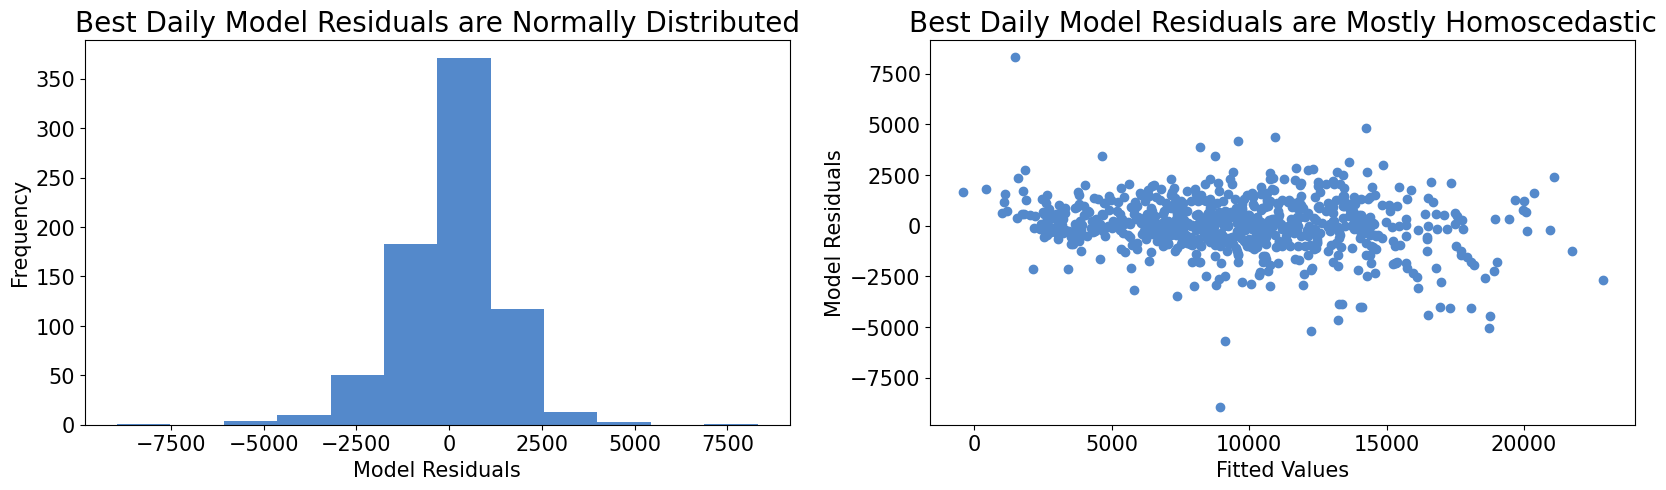

In [661]:
# To plot the residuals distribution 
plt.figure()
plt.subplots(1,2, figsize = (20,5))

# A histogram of the model residuals is plotted
plt.subplot(1,2,1)
plt.hist(model_resids, bins = 12, color = bakery.light_magpie)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Model Residuals', fontsize=15)
plt.title('Best Daily Model Residuals are Normally Distributed', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# A scatter plot of the model residuals vs fitted values is plotted
plt.subplot(1,2,2)
plt.scatter(model_fittedvals, model_resids,color = bakery.light_magpie)
plt.xlabel('Fitted Values', fontsize=15)
plt.ylabel('Model Residuals', fontsize=15)
plt.title('Best Daily Model Residuals are Mostly Homoscedastic', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [662]:
fig = px.line(x=model_fit.resid.index, y=model_fit.resid)
fig.update_layout(
    yaxis_title='Residuals', 
    xaxis_title='Date',
    title='SARIMAX Best Daily Model Residuals Show No Vairance'
)
fig
fig.show()

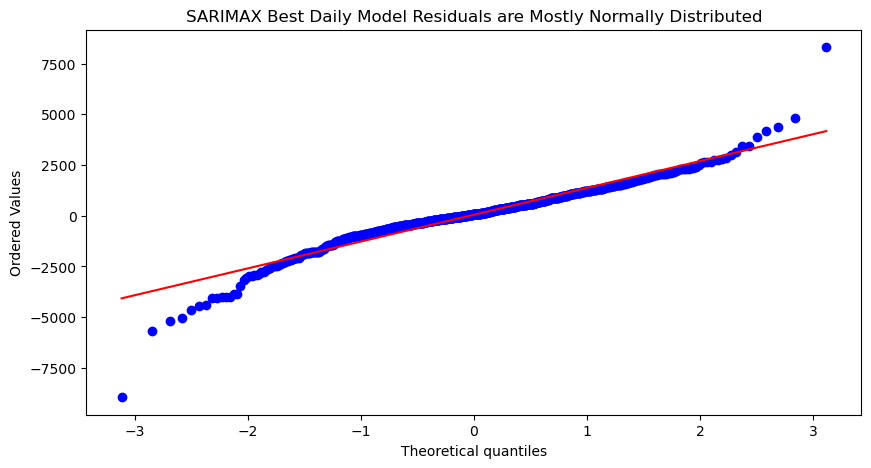

In [663]:
plt.figure(figsize=(10,5))
stats.probplot(model_fit.resid, dist="norm", plot = plt)
plt.title('SARIMAX Best Daily Model Residuals are Mostly Normally Distributed')
plt.show()

Finally, there should be no autocorrelation in the residuals:

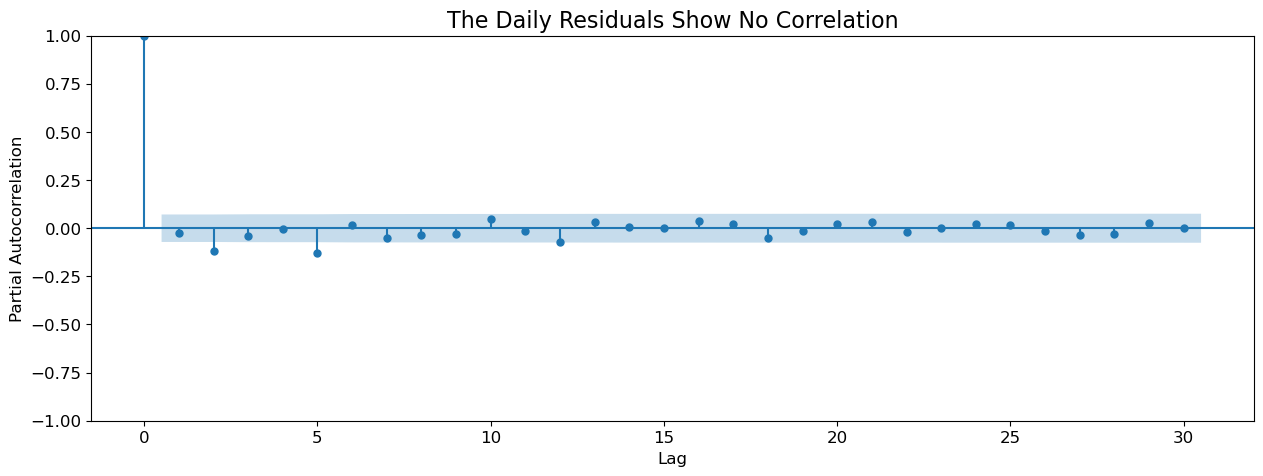

In [664]:
plt.figure(figsize=(15, 5))
plot_acf(model_fit.resid, lags=30, ax=plt.gca())
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The Daily Residuals Show No Correlation', fontsize=16)
plt.show()

## Daily Model Evaluation 
It can be seen from all the above plots that:
- The residuals are normally distributed 
- The fitted values vs residuals are mostly homoscedastic, with the slightest fan shape. However, this is not deemed significant and therefore the model assumptions are met
- There is no correlation between residuals

---

# 2. Weekly Revenue Forecast
## Selecting Baseline Parameters 
First the original weekly data and differenced data will be visualised to see if the data becomes stationary and then the `Dickey-Fuller Test` can be run to confirm that it is. 

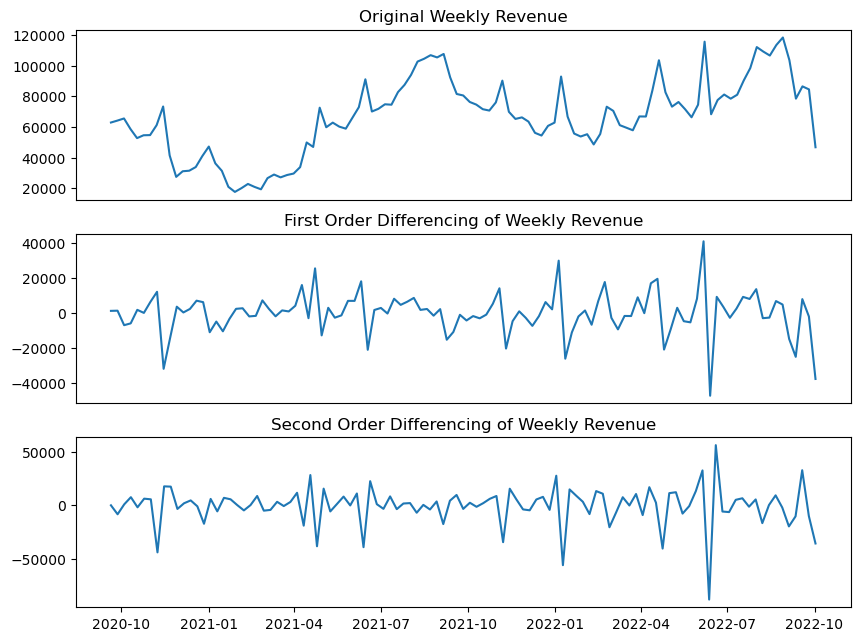

In [70]:
# Subplots of orginal and differenced daily data 
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(total_rev_weekly['Total_Revenue']); ax1.set_title('Original Weekly Revenue'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(total_rev_weekly['Total_Revenue'].diff()); ax2.set_title('First Order Differencing of Weekly Revenue'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(total_rev_weekly['Total_Revenue'].diff().diff()); ax3.set_title('Second Order Differencing of Weekly Revenue')
plt.show()

**Observations**: The first order differencing appears to be more stationary than the second. This will be confirmed with the `Dickey-Fuller Test`.

In [104]:
#perform augmented Dickey-Fuller test
adfuller(total_rev_weekly['Total_Revenue'].diff().dropna())

(-11.98616528236147,
 3.609012339190467e-22,
 0,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 2006.8166111418727)

**Dickey-Fuller Test Output**

|Revenue| Test Statistic | p-value |
|:--| :- | :- | 
|Daily|-11.986| 3.609 *e*<sup>-11</sup>|

The p-value is less than 0.05, therefore can reject the null hypothesis that the time series is non-stationary. Therefore, the `d parameter` for the baseline model shall be 1. 

---

## Determining the `p` and `q` Parameters for Weelky Baseline
Autocorrelation plots help determine if the successive elements of a time series are positively correlated, negatively correlated, or independent of each other. Analysing the autocorrelations is a key step in finding the right `p` and `q` parameters for (autoregressive) time series models.

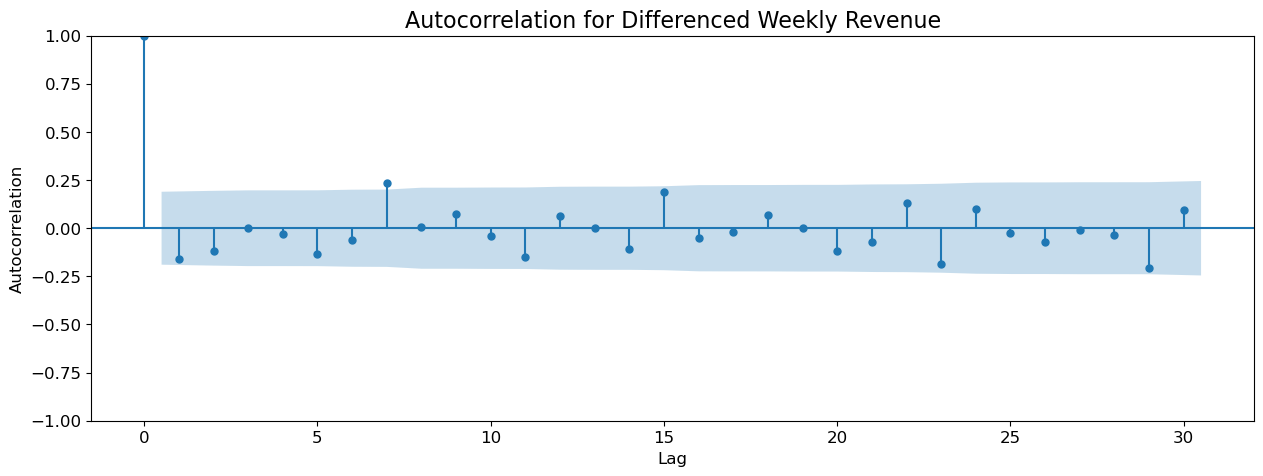

In [94]:
# Plotting the autocorrelation of the differenced data 
plt.figure(figsize=(15, 5))
plot_acf(total_rev_weekly['Total_Revenue'].diff().dropna(), lags=30, ax=plt.gca())
plt.ylabel('Autocorrelation', fontsize=12)
plt.xlabel('Lag', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Autocorrelation for Differenced Weekly Revenue', fontsize=16)
plt.show()

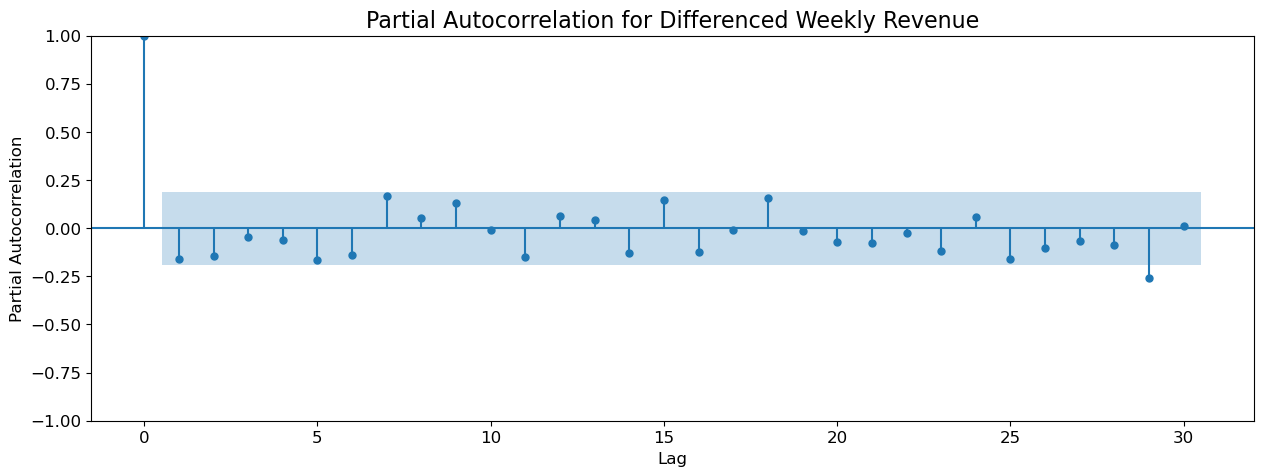

In [611]:
# To plot the partial autocorrelation of differenced data 
plt.figure(figsize=(15, 5))
plot_pacf(total_rev_weekly['Total_Revenue'].diff().dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Partial Autocorrelation for Differenced Weekly Revenue', fontsize=16)
plt.show()

## ACF and PACF Observations
Picking the right order parameter `p` and `q` , should include all or most of the significant correlations in the PACF plot.
- From the PACF plot it can be seen that `p = 3` for the daily baseline model

- From the ACF plot, it can be determined that for the baseline model `q = 1`. 

---

# Model 1 - Baseline Weekly Model
From the above differencing, ACF and PACF plots it is determined that the hyperparameters are:
- p = 0
- d = 1
- q = 0

**Splitting the Series for Modelling**

First the data is split into train and test sets as determined by the business, which is to predict the next 6 weeks of revenue.

*Therefore, anything on or before the date 19-08-2022 is train and post is test data.*

In [80]:
# Splitting the train and test data
train_weekly = total_rev_weekly.loc[total_rev_weekly.index <= '2022-08-19', 'Total_Revenue'].copy()
test_weekly = total_rev_weekly.loc[total_rev_weekly.index > '2022-08-19', 'Total_Revenue'].copy()

In [105]:
# First an empty results dataframe is created to track the accuracy of the models run
weekly_model_scores = pd.DataFrame()

In [106]:
p_param = 0
d_param = 1
q_param = 0

model = SARIMAX(train_weekly, order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  102
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -522.043
Date:                            Mon, 31 Oct 2022   AIC                           1048.086
Time:                                    19:40:27   BIC                           1051.870
Sample:                                09-06-2020   HQIC                          1049.522
                                     - 08-14-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -605.3694   1598.377     -0.379      0.705   -3738.132    2527.393
sigma2      1.051e+08   1.61e+07      6.530      0.000    7.35e+07    1.37e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):                14.87
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             0.82
Prob(H) (two-sided):                  0.13   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
predictions_1 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1)

In [108]:
bakery.train_forecast_plot(train_weekly,test_weekly, predictions_1, 'Model 1 - Baseline Weekly Forecast')

In [109]:
bakery.full_accuracy_report(test_weekly, predictions_1[test_weekly.index], 'weekly forecast')

The RMSE for the weekly forecast is: 10279.7

The MAE between the actual and weekly forecast revenue is 9334.52

The MAPE between the actual and weekly forecast revenue is 9.4%


In [110]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 1, 'N/A', 10279.7, 1048.086, '9.4%',
                                  'p=0, d=1, q=0')

Model   R2     RMSE       AIC MAPE (%)       Comments
0      1  N/A  10279.7  1048.086     9.4%  p=0, d=1, q=0

# SARIMAX Grid Search to Tune Hyperparameters 
The `evaluate_models` and `evaluate_sarimax_model` functions are used to tune the hyperparameters for the weekly forecast.

In [111]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
s_range = range(0,2)
warnings.filterwarnings("ignore")
bakery.evaluate_models(train_weekly.values, p_values, d_values, q_values, None, s_range, 52, 0.9)

The Best SARIMAX (2, 2, 2) SEASONAL(0, 1, 0, 52) MAPE=0.046


# Model 2 - Weekly Forecast Using Tuned Hyperparameters

In [113]:
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_weekly, order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Total_Revenue   No. Observations:                  102
Model:             SARIMAX(2, 2, 2)x(0, 1, [], 52)   Log Likelihood                -511.977
Date:                             Mon, 31 Oct 2022   AIC                           1035.954
Time:                                     20:22:05   BIC                           1047.181
Sample:                                 09-06-2020   HQIC                          1040.197
                                      - 08-14-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     87.4416    231.985      0.377      0.706    -367.241     542.124
ar.L1         -1.0087      0.178     -5.677      0.000      -1.357      -0.660
ar.L2         -0.0087      0.190     -0.046      0.963      -0.381       0.364
ma.L1         -0.0347      0.212     -0.164      0.870      -0.450       0.380
ma.L2         -0.9653      0.256     -3.769      0.000      -1.467      -0.463
sigma2      1.291e+08   3.34e-09   3.86e+16      0.000    1.29e+08    1.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                10.73
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.73
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.45e+37. Standard errors may be unstable.
"""

In [114]:
predictions_2 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1)

In [115]:
bakery.train_forecast_plot(train_weekly,test_weekly, predictions_2, 'Model 2 - Weekly Forecast with Tuned Parameters')

In [116]:
bakery.full_accuracy_report(test_weekly, predictions_2[test_weekly.index], 'weekly forecast')

The RMSE for the weekly forecast is: 9928.3

The MAE between the actual and weekly forecast revenue is 9311.25

The MAPE between the actual and weekly forecast revenue is 9.3%


In [117]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 2, 'N/A', 9928.3, 1035.954, '9.3%',
                                  'p=2,q=2,d=2')

Model   R2     RMSE       AIC MAPE (%)       Comments
0      1  N/A  10279.7  1048.086     9.4%  p=0, d=1, q=0
1      2  N/A   9928.3  1035.954     9.3%    p=2,q=2,d=2

# Model 3 - Baseline Weekly Forecast With Special Dates
As with the daily forecast, special dates will be added in the SARIMAX model to see if this improves the accuracy. First the special dates need to be resampled to be the same index as the weekly forecast and the values summed. 

In [646]:
# Splitting the train and test data
special_days = total_rev[['Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend']].copy()
special_days = special_days.resample('W').sum()
special_days = special_days[:(len(special_days)-1)]
train_ex = special_days.loc[special_days.index <= '2022-08-14'].copy()
test_ex = special_days.loc[special_days.index > '2022-08-14'].copy()

In [119]:
# Baseline model run with the original baseline hyperparameters 
p_param = 0
d_param = 1
q_param = 0

model = SARIMAX(train_weekly, exog=train_ex, 
                order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Total_Revenue   No. Observations:                  102
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -504.145
Date:                            Mon, 31 Oct 2022   AIC                           1022.290
Time:                                    20:22:14   BIC                           1035.533
Sample:                                09-06-2020   HQIC                          1027.314
                                     - 08-14-2022                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       -358.6439   1052.014     -0.341      0.733   -2420.554    1703.266
Bank_Holiday    1.861e+04   1.42e+05      0.131      0.896    -2.6e+05    2.98e+05
Closed_Xmas    -3.693e-13   7.51e-05  -4.92e-09      1.000      -0.000       0.000
School_Holiday  5839.7876   1.42e+05      0.041      0.967   -2.73e+05    2.85e+05
Weekday         9097.9195   1.42e+05      0.064      0.949    -2.7e+05    2.88e+05
Weekend         3008.9403   1.42e+05      0.021      0.983   -2.76e+05    2.82e+05
sigma2           5.06e+07   1.33e+07      3.812      0.000    2.46e+07    7.66e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.63   Prob(JB):                         0.62
Heteroskedasticity (H):               1.06   Skew:                             0.05
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.03e+24. Standard errors may be unstable.
"""

In [120]:
predictions_3 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1, exog=test_ex)

In [121]:
bakery.train_forecast_plot(train_weekly, test_weekly, predictions_3, 'Model 3 - Baseline Model Adding Special Days')

In [122]:
bakery.full_accuracy_report(test_weekly, predictions_3[test_weekly.index], 'weekly forecast with special days')

The RMSE for the weekly forecast with special days is: 9729.06

The MAE between the actual and weekly forecast with special days revenue is 8942.37

The MAPE between the actual and weekly forecast with special days revenue is 9.0%


In [123]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 3, 'N/A', 9729.06, 1022.290, '9.0%',
                                  'p=1,q=0,d=1, special dates added')

Model   R2      RMSE       AIC MAPE (%)                          Comments
0      1  N/A  10279.70  1048.086     9.4%                     p=0, d=1, q=0
1      2  N/A   9928.30  1035.954     9.3%                       p=2,q=2,d=2
2      3  N/A   9729.06  1022.290     9.0%  p=1,q=0,d=1, special dates added

# Model 4 - Tuning Hyperparameters with Speical Dates

In [621]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 7]
d_values = range(0, 3)
q_values = range(0, 3)
s_range = range(0,2)
warnings.filterwarnings("ignore")
bakery.evaluate_models(train_weekly.values, p_values, d_values, q_values, train_ex, s_range, 52, 0.9)

The Best SARIMAX (2, 2, 2) SEASONAL(0, 1, 0, 52) MAPE=0.046


In [124]:
# Run with best hyperparameters
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_weekly, exog = train_ex, order=(p_param, d_param, q_param),
                seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Total_Revenue   No. Observations:                  102
Model:             SARIMAX(2, 2, 2)x(0, 1, [], 52)   Log Likelihood                -495.932
Date:                             Mon, 31 Oct 2022   AIC                           1013.863
Time:                                     20:23:06   BIC                           1034.446
Sample:                                 09-06-2020   HQIC                          1021.642
                                      - 08-14-2022                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         37.2233    203.068      0.183      0.855    -360.782     435.229
Bank_Holiday    1.507e+04   8594.786      1.753      0.080   -1777.836    3.19e+04
Closed_Xmas        0.0263     12.710      0.002      0.998     -24.885      24.937
School_Holiday  3077.5137   8551.031      0.360      0.719   -1.37e+04    1.98e+04
Weekday         5768.2463   8632.302      0.668      0.504   -1.12e+04    2.27e+04
Weekend         -151.1718   8485.715     -0.018      0.986   -1.68e+04    1.65e+04
ar.L1             -0.8800      0.176     -5.003      0.000      -1.225      -0.535
ar.L2              0.1200      0.193      0.623      0.533      -0.258       0.498
ma.L1             -0.0246      0.329     -0.075      0.940      -0.670       0.621
ma.L2             -0.9728      0.316     -3.077      0.002      -1.593      -0.353
sigma2          5.438e+07      0.151   3.59e+08      0.000    5.44e+07    5.44e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.82   Prob(JB):                         0.72
Heteroskedasticity (H):               0.75   Skew:                            -0.15
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.43e+25. Standard errors may be unstable.
"""

In [125]:
predictions_4 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1, exog=test_ex)

In [126]:
bakery.train_forecast_plot(train_weekly, test_weekly, predictions_4, 
                           'Model 4 - Tuned Hyperparameters With Special Days')

In [127]:
bakery.full_accuracy_report(test_weekly, predictions_4[test_weekly.index], 'weekly forecast with special days')

The RMSE for the weekly forecast with special days is: 11068.52

The MAE between the actual and weekly forecast with special days revenue is 10114.64

The MAPE between the actual and weekly forecast with special days revenue is 10.1%


In [128]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 4, 'N/A', 11068.52, 1013.863, '10.1%',
                                  'p=2,q=2,d=2')

Model   R2      RMSE       AIC MAPE (%)                          Comments
0      1  N/A  10279.70  1048.086     9.4%                     p=0, d=1, q=0
1      2  N/A   9928.30  1035.954     9.3%                       p=2,q=2,d=2
2      3  N/A   9729.06  1022.290     9.0%  p=1,q=0,d=1, special dates added
3      4  N/A  11068.52  1013.863    10.1%                       p=2,q=2,d=2

# Model 5 - Removing Variables with P-Values Greater than 0.05
The 3 variables with the greatest p-values will be removed, leaving only `Bank_Holiday` and `Weekday` as the independent variables.

In [647]:
# Splitting the train and test data
special_days_reduced = special_days[['Bank_Holiday','Weekday']].copy()
train_ex = special_days_reduced.loc[special_days_reduced.index <= '2022-08-19'].copy()
test_ex = special_days_reduced.loc[special_days_reduced.index > '2022-08-19'].copy()

In [154]:
# Re-run with reduced variables
p_param = 2
d_param = 2
q_param = 2

model = SARIMAX(train_weekly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model_ex.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Total_Revenue   No. Observations:                  102
Model:             SARIMAX(2, 2, 2)x(0, 1, [], 52)   Log Likelihood                -498.687
Date:                             Mon, 31 Oct 2022   AIC                           1013.374
Time:                                     20:29:13   BIC                           1028.344
Sample:                                 09-06-2020   HQIC                          1019.031
                                      - 08-14-2022                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       93.3838    165.875      0.563      0.573    -231.725     418.493
Bank_Holiday  1.199e+04   1587.585      7.555      0.000    8882.103    1.51e+04
Weekday       2126.3326    859.765      2.473      0.013     441.224    3811.441
ar.L1           -0.9151      0.175     -5.240      0.000      -1.257      -0.573
ar.L2            0.0849      0.190      0.446      0.656      -0.288       0.458
ma.L1           -0.0229      0.324     -0.071      0.944      -0.658       0.612
ma.L2           -0.9771      0.304     -3.211      0.001      -1.573      -0.381
sigma2        6.328e+07   1.98e-08    3.2e+15      0.000    6.33e+07    6.33e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.60   Prob(JB):                         0.57
Heteroskedasticity (H):               0.84   Skew:                            -0.31
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.81e+39. Standard errors may be unstable.
"""

In [155]:
predictions_5 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1, exog=test_ex)

In [156]:
bakery.train_forecast_plot(train_weekly, test_weekly, predictions_5, 'Model 5 - Reducing Variables')

In [157]:
bakery.full_accuracy_report(test_weekly, predictions_5[test_weekly.index], 'weekly forecast with reduced variables')

The RMSE for the weekly forecast with reduced variables is: 10568.09

The MAE between the actual and weekly forecast with reduced variables revenue is 9574.39

The MAPE between the actual and weekly forecast with reduced variables revenue is 9.5%


In [134]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 5, 'N/A', 10568.09, 1012.726, '9.5%',
                                  'Removing Weekend, School Hol and Xmas')

Model   R2      RMSE       AIC MAPE (%)  \
0      1  N/A  10279.70  1048.086     9.4%   
1      2  N/A   9928.30  1035.954     9.3%   
2      3  N/A   9729.06  1022.290     9.0%   
3      4  N/A  11068.52  1013.863    10.1%   
4      5  N/A  10568.09  1012.726     9.5%   

                                Comments  
0                          p=0, d=1, q=0  
1                            p=2,q=2,d=2  
2       p=1,q=0,d=1, special dates added  
3                            p=2,q=2,d=2  
4  Removing Weekend, School Hol and Xmas

# Model 6 - Reducing Hyperparameters with P-Value Over Than 0.05
One of the autoregressive and moving average coefficients have p-values greater than 0.05, suggesting they are not statistically significant. Therefore, the `p` and `q` parameters will both be reduced to 1. 

In [158]:
# Reducing p/q values
p_param = 1
d_param = 2
q_param = 1

model = SARIMAX(train_weekly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Total_Revenue   No. Observations:                  102
Model:             SARIMAX(1, 2, 1)x(0, 1, [], 52)   Log Likelihood                -500.363
Date:                             Mon, 31 Oct 2022   AIC                           1012.726
Time:                                     20:29:22   BIC                           1023.953
Sample:                                 09-06-2020   HQIC                          1016.969
                                      - 08-14-2022                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       47.3047    105.177      0.450      0.653    -158.838     253.448
Bank_Holiday    1.2e+04   2049.735      5.853      0.000    7980.009     1.6e+04
Weekday       2129.0315   1074.113      1.982      0.047      23.808    4234.254
ar.L1            0.0067      0.209      0.032      0.974      -0.403       0.416
ma.L1           -0.9894      0.381     -2.600      0.009      -1.735      -0.244
sigma2         8.72e+07      0.010   8.55e+09      0.000    8.72e+07    8.72e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.62   Prob(JB):                         0.64
Heteroskedasticity (H):               0.93   Skew:                            -0.22
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.1e+26. Standard errors may be unstable.
"""

In [159]:
predictions_6 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1, exog=test_ex)

In [160]:
bakery.train_forecast_plot(train_weekly, test_weekly, predictions_6, 'Model 6 - Reducing Hyperparameters')

In [161]:
bakery.full_accuracy_report(test_weekly, predictions_6[test_weekly.index], 'Reduced parameters')

The RMSE for the Reduced parameters is: 9095.52

The MAE between the actual and Reduced parameters revenue is 8260.46

The MAPE between the actual and Reduced parameters revenue is 8.2%


In [164]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 6, 'N/A', 9095.52, 1012.726, '8.2%',
                                  'Reducing hyperparameters')

Model   R2      RMSE       AIC MAPE (%)  \
0      1  N/A  10279.70  1048.086     9.4%   
1      2  N/A   9928.30  1035.954     9.3%   
2      3  N/A   9729.06  1022.290     9.0%   
3      4  N/A  11068.52  1013.863    10.1%   
4      5  N/A  10568.09  1012.726     9.5%   
5      6  N/A   9095.52  1012.726     8.2%   

                                Comments  
0                          p=0, d=1, q=0  
1                            p=2,q=2,d=2  
2       p=1,q=0,d=1, special dates added  
3                            p=2,q=2,d=2  
4  Removing Weekend, School Hol and Xmas  
5               Reducing hyperparameters

# Model 7 - Reducing Hyperparameters with P-Value Over Than 0.05
The autoregressive coefficients has a p-value greater than 0.05, suggesting it is not statistically significant. Therefore, the `p` parameter will both be reduced to 0. 

In [648]:
# Reducing p parameter values
p_param = 0
d_param = 2
q_param = 1

model = SARIMAX(train_weekly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (0, 1, 0, 52), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Total_Revenue   No. Observations:                  102
Model:             SARIMAX(0, 2, 1)x(0, 1, [], 52)   Log Likelihood                -499.296
Date:                             Mon, 31 Oct 2022   AIC                           1008.592
Time:                                     23:26:12   BIC                           1017.948
Sample:                                 09-06-2020   HQIC                          1012.128
                                      - 08-14-2022                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       52.6858     65.405      0.806      0.421     -75.505     180.876
Bank_Holiday  1.212e+04   1514.938      7.999      0.000    9148.741    1.51e+04
Weekday       2675.4106    689.241      3.882      0.000    1324.522    4026.299
ma.L1           -0.9966      0.299     -3.333      0.001      -1.583      -0.411
sigma2        6.597e+07      0.001   1.16e+11      0.000     6.6e+07     6.6e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.64   Prob(JB):                         0.46
Heteroskedasticity (H):               0.95   Skew:                            -0.21
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.49e+28. Standard errors may be unstable.
"""

In [649]:
predictions_7 = model_fit.predict(start=0, end=len(train_weekly)+len(test_weekly)-1, exog=test_ex)

In [650]:
bakery.train_forecast_plot(train_weekly, test_weekly, predictions_7, 'Model 7 - Reducing Hyperparameters')

In [651]:
bakery.full_accuracy_report(test_weekly, predictions_7[test_weekly.index], 'Reduced parameters')

The RMSE for the Reduced parameters is: 9169.81

The MAE between the actual and Reduced parameters revenue is 8215.7

The MAPE between the actual and Reduced parameters revenue is 8.2%


In [173]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 7, 'N/A', 9169.81, 1008.592, '8.2%',
                                  'Reducing hyperparameters')

Model   R2      RMSE       AIC MAPE (%)  \
0      1  N/A  10279.70  1048.086     9.4%   
1      2  N/A   9928.30  1035.954     9.3%   
2      3  N/A   9729.06  1022.290     9.0%   
3      4  N/A  11068.52  1013.863    10.1%   
4      5  N/A  10568.09  1012.726     9.5%   
5      6  N/A   9095.52  1012.726     8.2%   
6      7  N/A   9169.81  1008.592     8.2%   

                                Comments  
0                          p=0, d=1, q=0  
1                            p=2,q=2,d=2  
2       p=1,q=0,d=1, special dates added  
3                            p=2,q=2,d=2  
4  Removing Weekend, School Hol and Xmas  
5               Reducing hyperparameters  
6               Reducing hyperparameters

---

# Weekly Revenue Model Results Discussion 
Of the 7 models that were run, model 7 produced the lowest AIC and MAPE scores, therefore is deemed the most accurate model for the weekly forecast. Model 6 is a close second, however it has a greater AIC score. 

The SARIMAX best weekly model also scored the lowest accuracy scores compared to the moving average and linear regression models, making it the most accurate model so far for predicting weekly revenue. 

#  Exploring Reisudals of Best Weekly Model
To further evaluate the best models performance, the model residuals will be explored. For an accurate linear model, the assumptions are that: 
- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables
- The ACF of the residuals should show no significant correlations - this can be tested by a Box-Pierce test

In [652]:
# The model residuals and fitted values are stored as new variables
model_resids = model_fit.resid 
model_fittedvals = model_fit.fittedvalues 

<Figure size 1000x750 with 0 Axes>

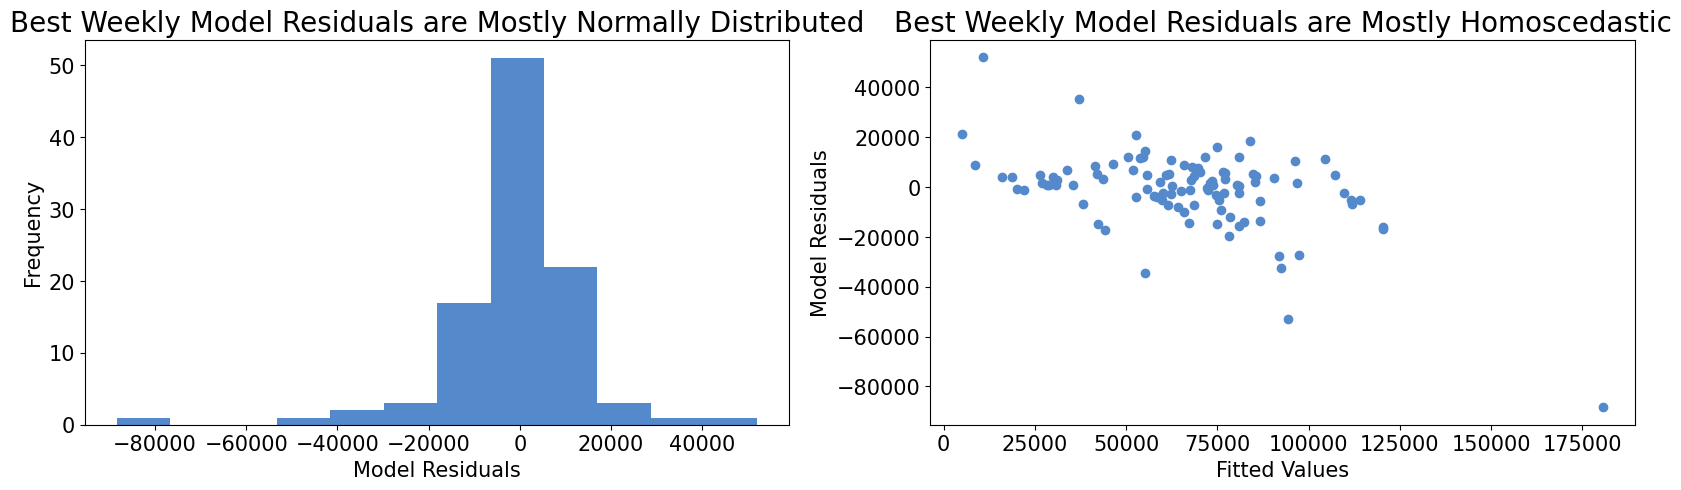

In [653]:
# To plot the residuals distribution 
plt.figure()
plt.subplots(1,2, figsize = (20,5))

# A histogram of the model residuals is plotted
plt.subplot(1,2,1)
plt.hist(model_resids, bins = 12, color = bakery.light_magpie)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Model Residuals', fontsize=15)
plt.title('Best Weekly Model Residuals are Mostly Normally Distributed', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# A scatter plot of the model residuals vs fitted values is plotted
plt.subplot(1,2,2)
plt.scatter(model_fittedvals, model_resids,color = bakery.light_magpie)
plt.xlabel('Fitted Values', fontsize=15)
plt.ylabel('Model Residuals', fontsize=15)
plt.title('Best Weekly Model Residuals are Mostly Homoscedastic', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [654]:
fig = px.line(x=model_fit.resid.index, y=model_fit.resid)
fig.update_layout(
    yaxis_title='Residuals', 
    xaxis_title='Date',
    title='SARIMAX Best Weekly Model Show Little Variance'
)
fig
fig.show()

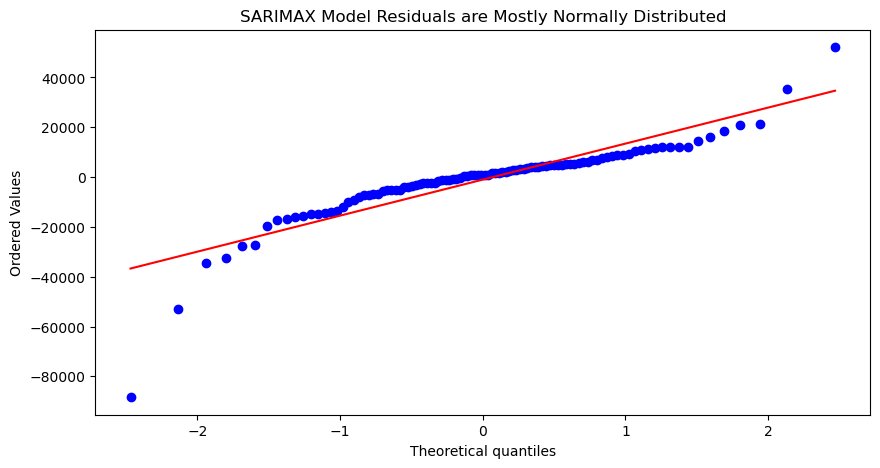

In [655]:
plt.figure(figsize=(10,5))
stats.probplot(model_fit.resid, dist="norm", plot = plt)
plt.title('SARIMAX Model Residuals are Mostly Normally Distributed')
plt.show()

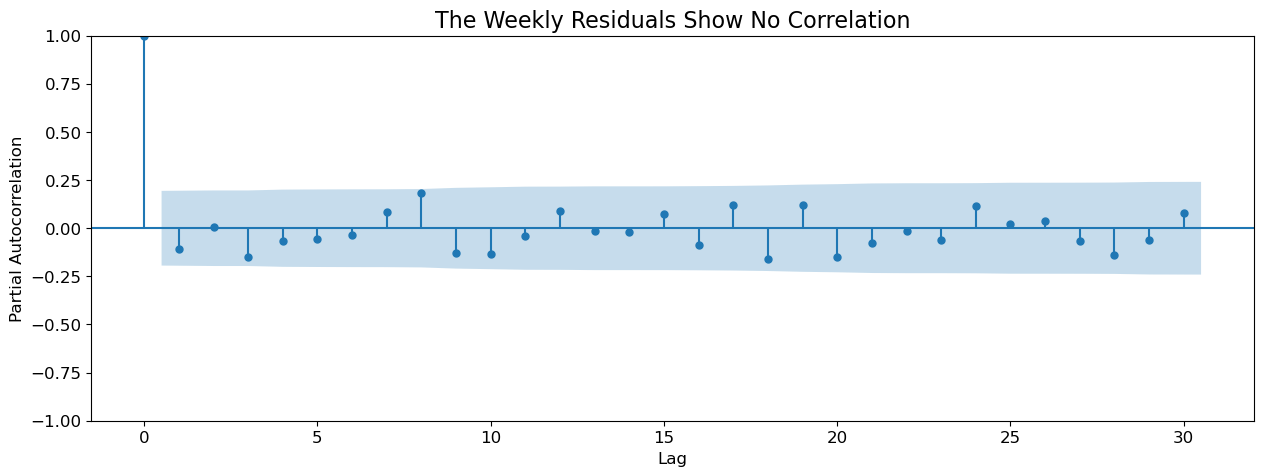

In [656]:
plt.figure(figsize=(15, 5))
plot_acf(model_fit.resid, lags=30, ax=plt.gca())
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The Weekly Residuals Show No Correlation', fontsize=16)
plt.show()

## Weekly Model Evaluation 
From the PACF plot and the model residuals vs fitted values it can be seen that there is little variance and no correlation between residuals. 

The residuals are also mostly normally distributed, with a slight left hand skew. This could be due to **UPADTE**

---

# 3. Monthly Revenue Forecast
## Selecting Baseline Parameters 
First the original weekly data and differenced data will be visualised to see if the data becomes stationary and then the `Dickey-Fuller Test` can be run to confirm that it is. 

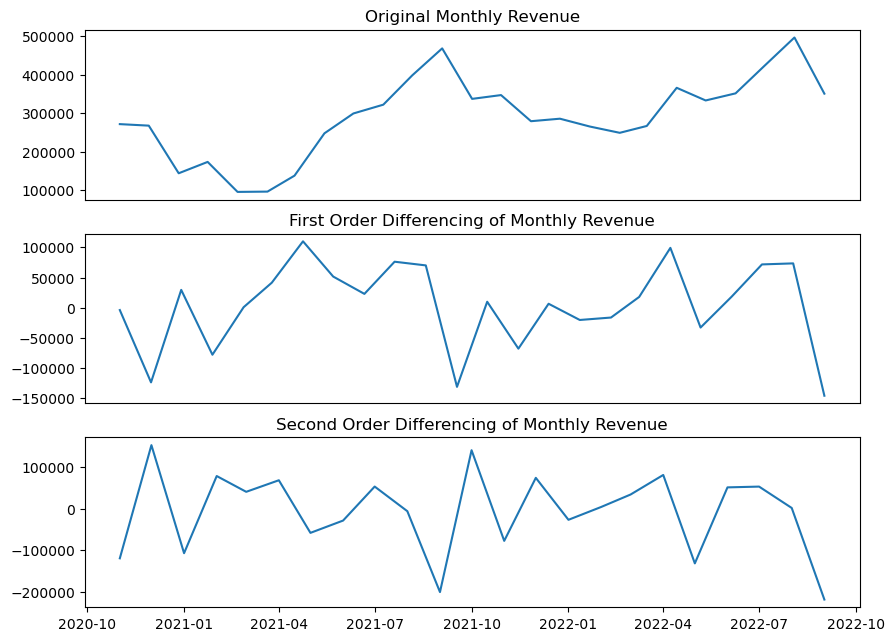

In [195]:
# Subplots of orginal and differenced daily data 
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(total_rev_monthly['Total_Revenue']); ax1.set_title('Original Monthly Revenue'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(total_rev_monthly['Total_Revenue'].diff()); ax2.set_title('First Order Differencing of Monthly Revenue'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(total_rev_monthly['Total_Revenue'].diff().diff()); ax3.set_title('Second Order Differencing of Monthly Revenue')
plt.show()

**Observations**: The first order differencing appears to be more stationary than the second. This will be confirmed with the `Dickey-Fuller Test`.

In [212]:
# To perform augmented Dickey-Fuller test on first order difference
adfuller(total_rev_monthly['Total_Revenue'].diff().dropna())

(-4.584943825120743,
 0.0001376800000181706,
 6,
 17,
 {'1%': -3.889265672705068,
  '5%': -3.0543579727254224,
  '10%': -2.66698384083045},
 348.1710803431318)

**Dickey-Fuller Test Output**

|Revenue| Test Statistic | p-value |
|:--| :- | :- | 
|Daily|-4.585| 0.00014|

The p-value is less than 0.05, therefore can reject the null hypothesis that the time series is non-stationary. Therefore, the `d parameter` for the baseline model shall be 1. 

---

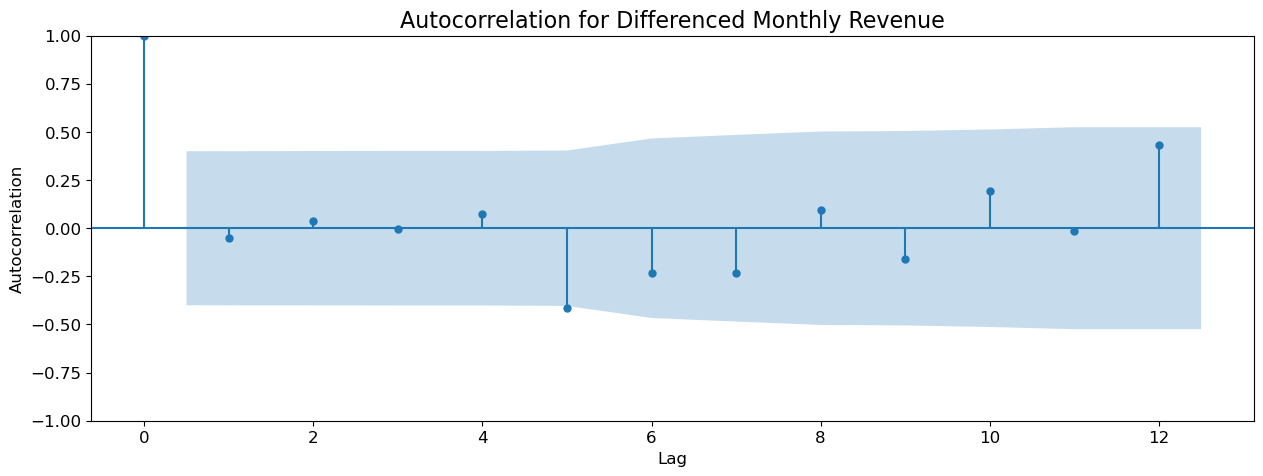

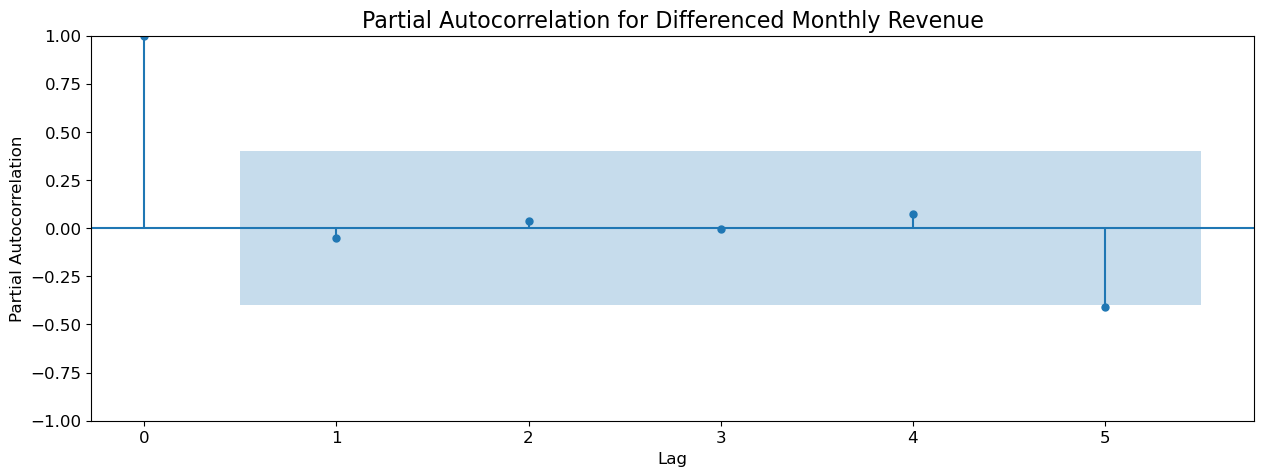

In [610]:
# Plotting the autocorrelation of the differenced data 
plt.figure(figsize=(15, 5))
plot_acf(total_rev_monthly['Total_Revenue'].diff().dropna(), lags=12, ax=plt.gca())
plt.ylabel('Autocorrelation', fontsize=12)
plt.xlabel('Lag', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Autocorrelation for Differenced Monthly Revenue', fontsize=16)
plt.show()

# To plot the partial autocorrelation of differenced data 
plt.figure(figsize=(15, 5))
plot_pacf(total_rev_monthly['Total_Revenue'].diff().dropna(), lags=5, ax=plt.gca(), method='ywm')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Partial Autocorrelation for Differenced Monthly Revenue', fontsize=16)
plt.show()

## ACF and PACF Observations
Picking the right order parameter `p` and `q` , should include all or most of the significant correlations in the PACF plot.
- From the PACF plot it can be seen that `p = 0` for the daily baseline model

- From the ACF plot, it can be determined that for the baseline model `q = 0`. 
or 1 and 1

# Model 1 - Baseline Monthly Model
From the above differencing, ACF and PACF plots it is determined that the hyperparameters are:
- p = 3
- d = 2
- q = 1

In [199]:
# Splitting the train and test data
train_monthly = total_rev_monthly.loc[total_rev_monthly.index <= '2022-03-01', 'Total_Revenue'].copy()
test_monthly = total_rev_monthly.loc[total_rev_monthly.index > '2022-03-01', 'Total_Revenue'].copy()

In [510]:
# First an empty results dataframe is created to track the accuracy of the models run
monthly_model_scores = pd.DataFrame()

In [218]:
# Baseline model run 
p_param = 0
d_param = 1
q_param = 0

model = SARIMAX(train_monthly, order=(p_param, d_param, q_param), seasonal_order = (0, 0, 0, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Total_Revenue   No. Observations:                   19
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -224.643
Date:                Mon, 31 Oct 2022   AIC                            453.287
Time:                        20:40:27   BIC                            455.068
Sample:                    09-01-2020   HQIC                           453.532
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -264.6989   1.65e+04     -0.016      0.987   -3.26e+04    3.21e+04
sigma2      4.052e+09    1.6e+09      2.525      0.012    9.07e+08     7.2e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.93   Prob(JB):                         0.62
Heteroskedasticity (H):               0.24   Skew:                            -0.54
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [219]:
predictions_1 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1)

In [220]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_1, 'Model 1 - Baseline Monthly Forecast')

In [221]:
bakery.full_accuracy_report(test_monthly, predictions_1[test_monthly.index], 'monthly forecast')

The RMSE for the monthly forecast is: 133669.38

The MAE between the actual and monthly forecast revenue is 120976.07

The MAPE between the actual and monthly forecast revenue is 30.0%


In [511]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 1, 'N/A', 133669.38, 1008.592, '30.0%',
                                  'Baseline, p=0, d=1, q=0')

Model   R2       RMSE       AIC MAPE (%)                 Comments
0      1  N/A  133669.38  1008.592    30.0%  Baseline, p=0, d=1, q=0

# SARIMAX Grid Search to Tune Hyperparameters 
The `evaluate_models` and `evaluate_sarimax_model` functions are used to tune the hyperparameters for the weekly forecast.

In [509]:
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)
s_range = range(0,2)
warnings.filterwarnings("ignore")
bakery.evaluate_models(train_monthly.values, p_values, d_values, q_values, None, s_range, 12, 0.9)

The Best SARIMAX (3, 1, 2) SEASONAL(1, 0, 1, 12) MAPE=0.005


# Model 2 - Monthly Forecast with Tuned Hyperparameters

In [512]:
# Re-run with the best hyperparameters
p_param = 3
d_param = 1
q_param = 2

model= SARIMAX(train_monthly, order=(p_param, d_param, q_param), seasonal_order = (1, 0, 1, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Total_Revenue   No. Observations:                   19
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -222.625
Date:                              Mon, 31 Oct 2022   AIC                            463.250
Time:                                      21:53:40   BIC                            471.264
Sample:                                  09-01-2020   HQIC                           464.355
                                       - 03-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.176e+04   5.81e+05      0.020      0.984   -1.13e+06    1.15e+06
ar.L1         -0.1654      0.787     -0.210      0.834      -1.709       1.378
ar.L2          0.6517      0.641      1.016      0.309      -0.605       1.908
ar.L3         -0.1263      0.347     -0.364      0.716      -0.806       0.554
ma.L1          0.0120     69.022      0.000      1.000    -135.270     135.294
ma.L2         -0.9878     73.273     -0.013      0.989    -144.601     142.625
ar.S.L12      -0.9463     93.577     -0.010      0.992    -184.353     182.461
ma.S.L12       0.8168    168.864      0.005      0.996    -330.150     331.784
sigma2      2.673e+09      0.062    4.3e+10      0.000    2.67e+09    2.67e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.78   Prob(JB):                         0.66
Heteroskedasticity (H):               0.97   Skew:                            -0.08
Prob(H) (two-sided):                  0.97   Kurtosis:                         1.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.24e+30. Standard errors may be unstable.
"""

In [513]:
predictions_2 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1)

In [514]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_2, 'Model 2 - Monthly Forecast After Grid Search')

In [515]:
bakery.full_accuracy_report(test_monthly, predictions_2[test_monthly.index], 'monthly forecast')

The RMSE for the monthly forecast is: 111963.55

The MAE between the actual and monthly forecast revenue is 94077.53

The MAPE between the actual and monthly forecast revenue is 22.8%


In [516]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 2, 'N/A', 111963.55, 463.250, '22.8%',
                                  'Tuned parameters, p=3, d=1, q=1')

Model   R2       RMSE       AIC MAPE (%)                         Comments
0      1  N/A  133669.38  1008.592    30.0%          Baseline, p=0, d=1, q=0
1      2  N/A  111963.55   463.250    22.8%  Tuned parameters, p=3, d=1, q=1

# Model 3 - Reducing Hyperparameters with P-Value Over Than 0.05
All of the autoregressive and the moving average coefficients have p-values greater than 0.05, suggesting they are not statistically significant. Therefore, the `p` and `q` parameters will both be reduced to 0.

In [517]:
# Re-run with the best hyperparameters
p_param = 0
d_param = 1
q_param = 0

model= SARIMAX(train_monthly, order=(p_param, d_param, q_param), seasonal_order = (0, 0, 0, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Total_Revenue   No. Observations:                   19
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -224.643
Date:                Mon, 31 Oct 2022   AIC                            453.287
Time:                        21:54:28   BIC                            455.068
Sample:                    09-01-2020   HQIC                           453.532
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -264.6989   1.65e+04     -0.016      0.987   -3.26e+04    3.21e+04
sigma2      4.052e+09    1.6e+09      2.525      0.012    9.07e+08     7.2e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.93   Prob(JB):                         0.62
Heteroskedasticity (H):               0.24   Skew:                            -0.54
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [518]:
predictions_3 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1)

In [521]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_3, 'Model 3 - Monthly Forecast Reducing Parameters')

In [522]:
bakery.full_accuracy_report(test_monthly, predictions_3[test_monthly.index], 'monthly forecast')

The RMSE for the monthly forecast is: 133669.38

The MAE between the actual and monthly forecast revenue is 120976.07

The MAPE between the actual and monthly forecast revenue is 30.0%


In [523]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 3, 'N/A', 133669.38, 453.287, '30.0%',
                                  'Reduced parameters, p=0, d=2, q=0')

Model   R2       RMSE       AIC MAPE (%)                           Comments
0      1  N/A  133669.38  1008.592    30.0%            Baseline, p=0, d=1, q=0
1      2  N/A  111963.55   463.250    22.8%    Tuned parameters, p=3, d=1, q=1
2      3  N/A  133669.38   453.287    30.0%  Reduced parameters, p=0, d=2, q=0

# Model 4 - Baseline Model Adding Special Dates 

In [637]:
# Splitting the train and test data
special_days = total_rev[['Bank_Holiday','Closed_Xmas','School_Holiday','Weekday','Weekend']].copy()
special_days = special_days.resample('MS').sum()
train_ex = special_days.loc[special_days.index <= '2022-03-01'].copy()
test_ex = special_days.loc[special_days.index > '2022-03-01'].copy()

In [525]:
# Run with baseline hyperparameters
p_param = 0
d_param = 1
q_param = 0

model = SARIMAX(train_monthly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (0, 0, 0, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Total_Revenue   No. Observations:                   19
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -217.090
Date:                Mon, 31 Oct 2022   AIC                            448.180
Time:                        21:55:34   BIC                            454.412
Sample:                    09-01-2020   HQIC                           449.039
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -1916.9440   1.39e+04     -0.138      0.890   -2.92e+04    2.53e+04
Bank_Holiday    2.458e+04   2.23e+04      1.105      0.269    -1.9e+04    6.82e+04
Closed_Xmas     1197.6223   3.11e+04      0.038      0.969   -5.98e+04    6.22e+04
School_Holiday  3.111e+04   1.21e+04      2.569      0.010    7374.694    5.48e+04
Weekday         2.974e+04    1.5e+04      1.983      0.047     351.806    5.91e+04
Weekend         2.139e+04   1.47e+04      1.459      0.144   -7339.553    5.01e+04
sigma2          1.751e+09   8.35e+08      2.095      0.036    1.13e+08    3.39e+09
===================================================================================
Ljung-Box (L1) (Q):                   8.95   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.00   Prob(JB):                         0.56
Heteroskedasticity (H):               0.22   Skew:                             0.62
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [526]:
predictions_4 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1, exog=test_ex)

In [527]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_4, 
                           'Model 4 - Baseline Monthly Forecast Adding Special Dates')

In [528]:
bakery.full_accuracy_report(test_monthly, predictions_4[test_monthly.index], 'monthly forecast with special dates')

The RMSE for the monthly forecast with special dates is: 109276.81

The MAE between the actual and monthly forecast with special dates revenue is 105464.58

The MAPE between the actual and monthly forecast with special dates revenue is 27.0%


In [529]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 4, 'N/A', 109276.81, 448.180, '27.0%',
                                  'Baseline special dates, p=0, d=1, q=0')

Model   R2       RMSE       AIC MAPE (%)  \
0      1  N/A  133669.38  1008.592    30.0%   
1      2  N/A  111963.55   463.250    22.8%   
2      3  N/A  133669.38   453.287    30.0%   
3      4  N/A  109276.81   448.180    27.0%   

                                Comments  
0                Baseline, p=0, d=1, q=0  
1        Tuned parameters, p=3, d=1, q=1  
2      Reduced parameters, p=0, d=2, q=0  
3  Baseline special dates, p=0, d=1, q=0

# Model 5 - Tuned Hyperparameters with Special Dates

In [530]:
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)
s_range = range(0,2)
warnings.filterwarnings("ignore")
bakery.evaluate_models(train_monthly.values, p_values, d_values, q_values, train_ex, s_range, 12, 0.9)

The Best SARIMAX (3, 1, 2) SEASONAL(1, 0, 1, 12) MAPE=0.005


In [638]:
# Run with best hyperparameters
p_param = 3
d_param = 1
q_param = 2

model = SARIMAX(train_monthly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 0, 1, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Total_Revenue   No. Observations:                   19
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -202.625
Date:                              Mon, 31 Oct 2022   AIC                            433.249
Time:                                      23:21:08   BIC                            445.714
Sample:                                  09-01-2020   HQIC                           434.968
                                       - 03-01-2022                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       8918.4489   3.16e+04      0.282      0.778    -5.3e+04    7.08e+04
Bank_Holiday    2.458e+04   9076.292      2.709      0.007    6794.609    4.24e+04
Closed_Xmas     1197.6227   1.55e+04      0.077      0.939   -2.92e+04    3.16e+04
School_Holiday  3.111e+04   9845.378      3.160      0.002    1.18e+04    5.04e+04
Weekday         2.974e+04   8818.769      3.372      0.001    1.25e+04     4.7e+04
Weekend         2.139e+04   1.37e+04      1.561      0.118   -5465.917    4.83e+04
ar.L1              1.6206      0.185      8.747      0.000       1.258       1.984
ar.L2             -0.8997      0.287     -3.139      0.002      -1.462      -0.338
ar.L3              0.0184      0.138      0.134      0.893      -0.251       0.288
ma.L1             -1.5524      0.137    -11.308      0.000      -1.821      -1.283
ma.L2              0.8925      0.151      5.904      0.000       0.596       1.189
ar.S.L12          -0.9537      6.907     -0.138      0.890     -14.490      12.583
ma.S.L12           0.9705      7.450      0.130      0.896     -13.632      15.573
sigma2          3.615e+08      3.873   9.33e+07      0.000    3.61e+08    3.61e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.42   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.12   Prob(JB):                         0.90
Heteroskedasticity (H):               0.78   Skew:                            -0.07
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+23. Standard errors may be unstable.
"""

In [532]:
predictions_5 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1, exog=test_ex)

In [533]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_5, 
                           'Model 5 - Monthly Forecast with Special Dates and Tuned Parameters')

In [534]:
bakery.full_accuracy_report(test_monthly, predictions_5[test_monthly.index], 'monthly forecast with special dates')

The RMSE for the monthly forecast with special dates is: 36553.08

The MAE between the actual and monthly forecast with special dates revenue is 26064.25

The MAPE between the actual and monthly forecast with special dates revenue is 7.1%


In [535]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 5, 'N/A', 36553.08, 433.249, '7.1%',
                                  'Tuned parameters, p=3, d=1, q=2')

Model   R2       RMSE       AIC MAPE (%)  \
0      1  N/A  133669.38  1008.592    30.0%   
1      2  N/A  111963.55   463.250    22.8%   
2      3  N/A  133669.38   453.287    30.0%   
3      4  N/A  109276.81   448.180    27.0%   
4      5  N/A   36553.08   433.249     7.1%   

                                Comments  
0                Baseline, p=0, d=1, q=0  
1        Tuned parameters, p=3, d=1, q=1  
2      Reduced parameters, p=0, d=2, q=0  
3  Baseline special dates, p=0, d=1, q=0  
4        Tuned parameters, p=3, d=1, q=2

# Model 6 - Removing Variables with P-Values Greater than 0.05
`Bank_Holiday` and `Closed_Xmas` will be removed as they are the two independent variables with the greatest p-values. 

In [635]:
train_ex_red=train_ex.drop(columns=['Closed_Xmas', 'Bank_Holiday'])
test_ex_red = test_ex.drop(columns=['Closed_Xmas', 'Bank_Holiday'])

In [636]:
# Run with reduced hyperparameters
p_param = 3
d_param = 1
q_param = 2

model = SARIMAX(train_monthly, exog=train_ex_red,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 0, 1, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Total_Revenue   No. Observations:                   19
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -214.455
Date:                              Mon, 31 Oct 2022   AIC                            452.911
Time:                                      23:20:53   BIC                            463.595
Sample:                                  09-01-2020   HQIC                           454.384
                                       - 03-01-2022                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       9635.4349   4.53e+05      0.021      0.983   -8.79e+05    8.98e+05
School_Holiday  2.436e+04   5364.635      4.540      0.000    1.38e+04    3.49e+04
Weekday         1.764e+04   5084.647      3.470      0.001    7678.105    2.76e+04
Weekend         2.524e+04   7731.402      3.265      0.001    1.01e+04    4.04e+04
ar.L1             -0.0307      8.684     -0.004      0.997     -17.050      16.989
ar.L2              0.3614      1.074      0.337      0.736      -1.744       2.466
ar.L3             -0.0370      2.482     -0.015      0.988      -4.902       4.828
ma.L1              0.2583      8.615      0.030      0.976     -16.627      17.144
ma.L2             -0.1018      2.937     -0.035      0.972      -5.858       5.654
ar.S.L12           0.3090     34.497      0.009      0.993     -67.304      67.922
ma.S.L12          -0.1630     35.261     -0.005      0.996     -69.274      68.948
sigma2          7.436e+08    478.999   1.55e+06      0.000    7.44e+08    7.44e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.37   Prob(JB):                         0.70
Heteroskedasticity (H):               1.09   Skew:                             0.45
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.97e+21. Standard errors may be unstable.
"""

In [597]:
predictions_6 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1, exog=test_ex_red)

In [590]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_6, 
                           'Model 6 - Monthly Forecast Removing Xmas and Bank Holiday')

In [574]:
bakery.full_accuracy_report(test_monthly, predictions_6[test_monthly.index], 
                            'monthly forecast reducing hyperparameters')

The RMSE for the monthly forecast reducing hyperparameters is: 42291.41

The MAE between the actual and monthly forecast reducing hyperparameters revenue is 35348.57

The MAPE between the actual and monthly forecast reducing hyperparameters revenue is 9.4%


In [589]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 6, 'N/A', 42291.41, 452.911, '9.4%',
                                  'Removing Xmas, weekday, p=3, d=1, q=2')

Model   R2       RMSE       AIC MAPE (%)  \
0      1  N/A  133669.38  1008.592    30.0%   
1      2  N/A  111963.55   463.250    22.8%   
2      3  N/A  133669.38   453.287    30.0%   
3      4  N/A  109276.81   448.180    27.0%   
4      5  N/A   36553.08   433.249     7.1%   
5      6  N/A   42291.41   452.911     9.4%   

                                Comments  
0                Baseline, p=0, d=1, q=0  
1        Tuned parameters, p=3, d=1, q=1  
2      Reduced parameters, p=0, d=2, q=0  
3  Baseline special dates, p=0, d=1, q=0  
4        Tuned parameters, p=3, d=1, q=2  
5  Removing Xmas, weekday, p=3, d=1, q=2

# Model 7 -  Reducing Hyperparameters with P-Values greater than 0.05
All of the autoregressive and the moving average coefficients have p-values greater than 0.05, therefore will be reduced to 0 for the next iteration of the model.

In [598]:
# Run with best hyperparameters
p_param = 0
d_param = 2
q_param = 0

model = SARIMAX(train_monthly, exog=train_ex_red,
                      order=(p_param, d_param, q_param), seasonal_order = (0, 0, 0, 12), trend='c')
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Total_Revenue   No. Observations:                   19
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -205.267
Date:                Mon, 31 Oct 2022   AIC                            420.533
Time:                        22:07:37   BIC                            424.699
Sample:                    09-01-2020   HQIC                           420.947
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       5111.5752   1.16e+04      0.439      0.661   -1.77e+04    2.79e+04
School_Holiday  2.536e+04   6162.682      4.116      0.000    1.33e+04    3.74e+04
Weekday         1.932e+04   6575.754      2.938      0.003    6428.552    3.22e+04
Weekend         2.448e+04   6918.843      3.538      0.000    1.09e+04     3.8e+04
sigma2            1.8e+09   1.13e+09      1.600      0.110   -4.06e+08    4.01e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.61   Prob(JB):                         0.72
Heteroskedasticity (H):               0.49   Skew:                            -0.44
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [599]:
predictions_7 = model_fit.predict(start=0, end=len(train_monthly)+len(test_monthly)-1, exog=test_ex_red)

In [591]:
bakery.train_forecast_plot(train_monthly, test_monthly, predictions_7, 
                           'Model 7 - Monthly Forecast Reducing Hyperparameters')

In [579]:
bakery.full_accuracy_report(test_monthly, predictions_7[test_monthly.index], 
                            'monthly forecast reducing special dates')

The RMSE for the monthly forecast reducing special dates is: 83060.87

The MAE between the actual and monthly forecast reducing special dates revenue is 63000.77

The MAPE between the actual and monthly forecast reducing special dates revenue is 16.5%


In [592]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 7, 'N/A', 83060.87, 420.533, '16.5%',
                                  'Reducing hyperparameters, p=0, d=1, q=0')

Model   R2       RMSE       AIC MAPE (%)  \
0      1  N/A  133669.38  1008.592    30.0%   
1      2  N/A  111963.55   463.250    22.8%   
2      3  N/A  133669.38   453.287    30.0%   
3      4  N/A  109276.81   448.180    27.0%   
4      5  N/A   36553.08   433.249     7.1%   
5      6  N/A   42291.41   452.911     9.4%   
6      7  N/A   83060.87   420.533    16.5%   

                                  Comments  
0                  Baseline, p=0, d=1, q=0  
1          Tuned parameters, p=3, d=1, q=1  
2        Reduced parameters, p=0, d=2, q=0  
3    Baseline special dates, p=0, d=1, q=0  
4          Tuned parameters, p=3, d=1, q=2  
5    Removing Xmas, weekday, p=3, d=1, q=2  
6  Reducing hyperparameters, p=0, d=1, q=0

---

# Monthly Revenue Model Results Discussion 
Of the 7 models that were run, model 5 produced the lowest AIC, RMSE and MAPE scores, therefore is deemed the most accurate model for the monthly forecast. This has also scored the lowest accuracy scores compared to the moving average and linear regression models, making it the most accurate model so far for predicting monthly revenue. 

#  Exploring Reisudals of Best Monthly Model
To further evaluate the best models performance, the model residuals will be explored. For an accurate linear model, the assumptions are that: 
- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables
- The ACF of the residuals should show no significant correlations 

In [639]:
# Re-running best model 
p_param = 3
d_param = 1
q_param = 2

model = SARIMAX(train_monthly, exog=train_ex,
                      order=(p_param, d_param, q_param), seasonal_order = (1, 0, 1, 12), trend='c')
model_fit = model.fit(disp=0)

In [640]:
# The model residuals and fitted values are stored as new variables
model_resids = model_fit.resid 
model_fittedvals = model_fit.fittedvalues 

<Figure size 1000x750 with 0 Axes>

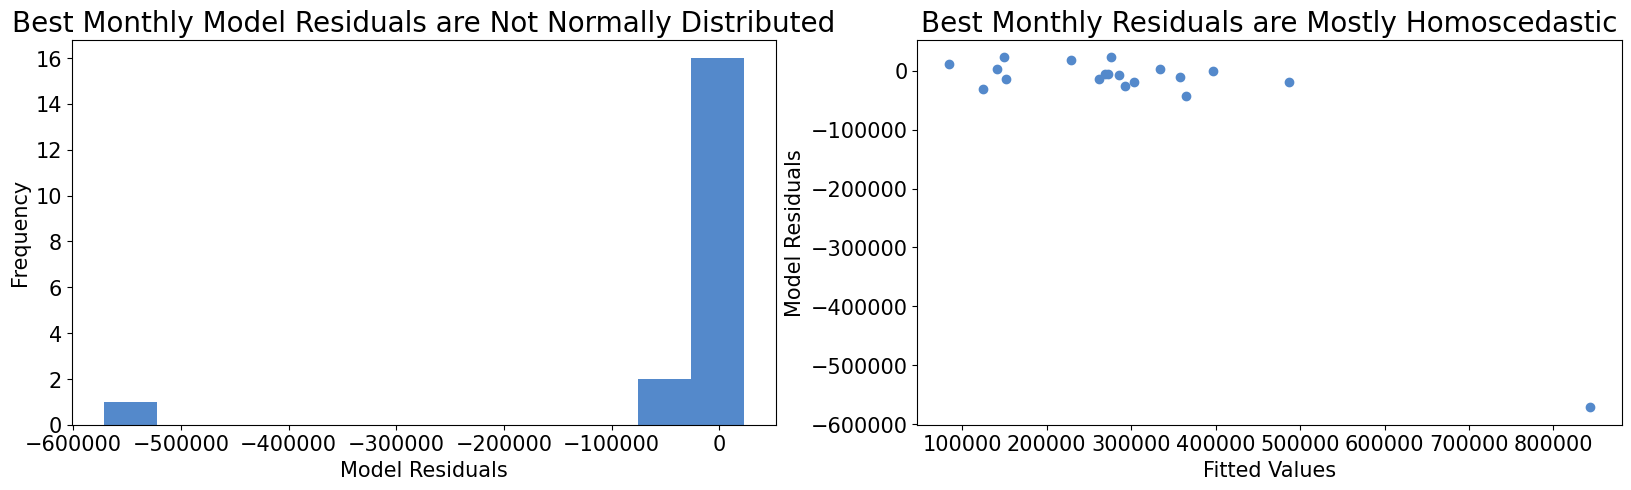

In [641]:
# To plot the residuals distribution 
plt.figure()
plt.subplots(1,2, figsize = (20,5))

# A histogram of the model residuals is plotted
plt.subplot(1,2,1)
plt.hist(model_resids, bins = 12, color = bakery.light_magpie)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Model Residuals', fontsize=15)
plt.title('Best Monthly Model Residuals are Not Normally Distributed', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# A scatter plot of the model residuals vs fitted values is plotted
plt.subplot(1,2,2)
plt.scatter(model_fittedvals, model_resids,color = bakery.light_magpie)
plt.xlabel('Fitted Values', fontsize=15)
plt.ylabel('Model Residuals', fontsize=15)
plt.title('Best Monthly Residuals are Mostly Homoscedastic', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [643]:
fig = px.line(x=model_fit.resid.index, y=model_fit.resid)
fig.update_layout(
    yaxis_title='Residuals', 
    xaxis_title='Date',
    title='Best Monthly Model Residuals Show Little Variance'
)
fig
fig.show()

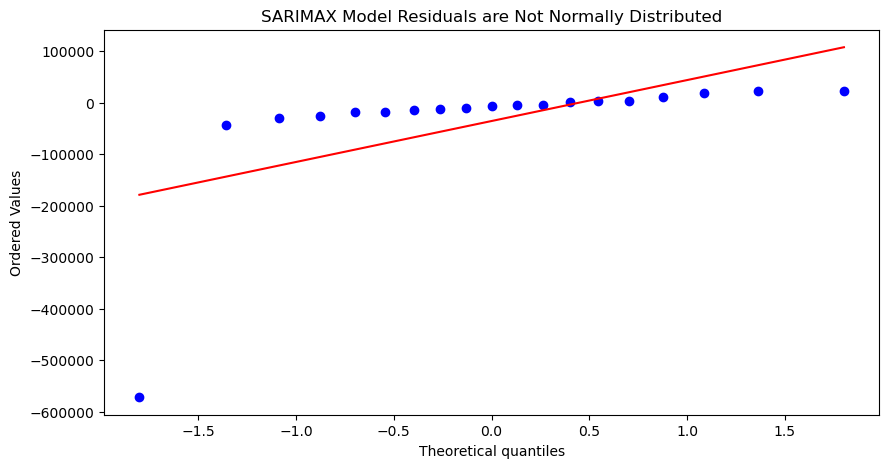

In [644]:
plt.figure(figsize=(10,5))
stats.probplot(model_fit.resid, dist="norm", plot = plt)
plt.title('SARIMAX Model Residuals are Not Normally Distributed')
plt.show()

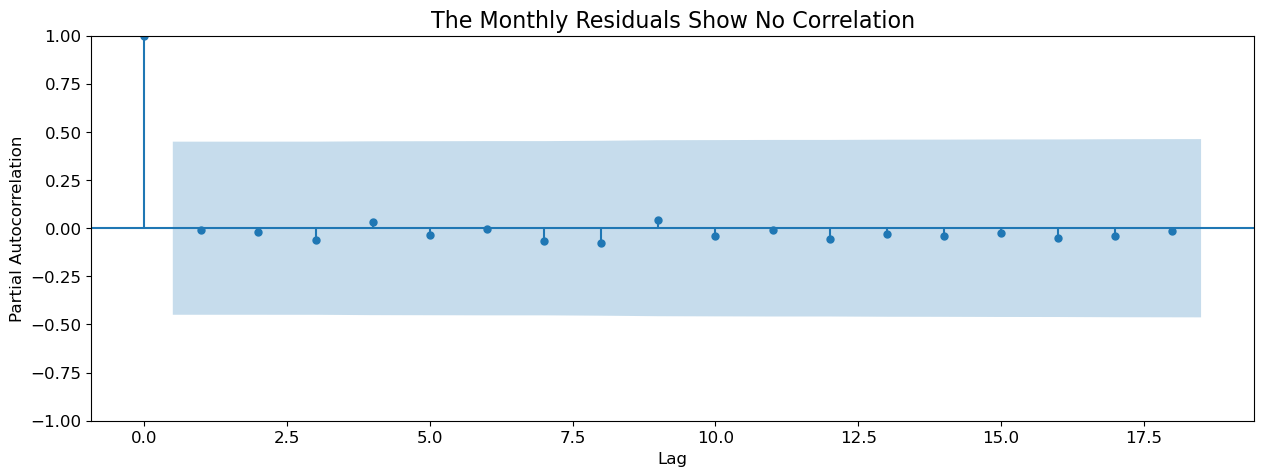

In [645]:
plt.figure(figsize=(15, 5))
plot_acf(model_fit.resid, lags=18, ax=plt.gca())
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('The Monthly Residuals Show No Correlation', fontsize=16)
plt.show()

## Monthly Model Evaluation 
From the PACF plot and the model residuals vs fitted values it can be seen that there is little variance and no correlation between residuals

However, the residuals are not normally distributed, which makes the model less **UPATE** reliable/accurate. This is most likely due to the p-values of some of the coefficients being greater than 0.05 and the few data points used in the dataset. In ideal time series models there would be a minimum of 4 years worth of data, not 2. 

# Summary 
The baseline models for each forecast are summarised in the table below, along with their MAPE scores and model number.

|Forecast| Model | MAPE |
|:--| :- | :- | 
|Daily|7| 5.9 %|
|Weekly|7| 8.2 %|
|Monthly|5| 7.1 %|

All of these models are now the leading and best models compared to the moving average and linear regression models, which have their MAPE scores summarised below. 

|Model| Daily MAPE | Weekly MAPE | Monthly MAPE|
|:--| :- | :- | :--|
|Moving Average|20.7 %| 24.8 %|  17.0 % |
|Linear |7.7 %| 9.9 %| 13.3 %|
|SARIMAX|5.9 %|8.2 %| 7.1 %|

|MAPE Score| Moving Average | Linear Regression | SARIMAX|
|:--| :- | :- | :--|
|Daily|20.7 %| 7.7 %|  5.9 % |
|Weekly |24.8 %| 9.9 %| 8.2 %|
|Monthly|17.0 %|13.3 %| 7.1 %|



---

# Further Improvements
Further improvements that could be made to the models are: 
- Re-run the analysis with more historic revenue data, inparticular for the weekly and monthly forecasts which have fewer data points 

# Next Steps
- Facebook Prophet models will be developed for the daily, weekly or monthly forecast to see if this improves the accuracy from the SARIMAX, linear regression and baseline models

>[Return to Contents](#Contents)